In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import cooler
import bioframe

import cooltools
import cooltools.expected
from cooltools import snipping

import cooltools.lib.plotting
# Set up parallelization
import multiprocess

from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
from scipy import interpolate
from mpl_toolkits.axes_grid import make_axes_locatable
import pyBigWig
import csv

from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
from cooltools.insulation import calculate_insulation_score, find_boundaries

import cooltools.eigdecomp
import cooltools.saddle
from scipy.stats import pearsonr
from scipy import linalg
from scipy.signal import argrelextrema
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import itertools
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

<ipython-input-1-e40b24965044>:21: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import make_axes_locatable


In [2]:
clr_emb = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_spreadingrev/DJ73_DJ74_ce10_30_2000_raw.cool")
clr_L3 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK15_JK89_JK90_30_2000_raw.cool")

clr_emb_5kb = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_spreadingrev/DJ73_DJ74_ce10_30_5000_raw.cool")
clr_L3_5kb = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK15_JK89_JK90_30_5000_raw.cool")

####### reps
clr_emb_1 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/DJ73_ce10_30_2000_raw.cool")
clr_emb_2 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/DJ74_ce10_30_2000_raw.cool")
clr_L3_1 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK15_30_2000_raw.cool")
clr_L3_2 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK89_JK90_30_2000_raw.cool")


In [3]:
####### load chipseq, regions, annotations ########
# DPY27
dpy27_emb = pyBigWig.open("/scratch/kimj50/Jun_ChIP/spreading_revision_v4/emb_rescale_ratio_bw_avg/N2_CJ132.N2_CJ39.bedgraph_MAPQ1_ratio_emb_rescale_Acenter.bw")
dpy27_L3 = pyBigWig.open("/scratch/kimj50/Jun_ChIP/spreading_revision_v4/L3_rescale_ratio_bw_avg/N2_JK64.N2_JK65.N2_JK66.bedgraph_MAPQ1_ratio_L3_rescale_Acenter.bw")

# SDC3
sdc3_emb = pyBigWig.open("/scratch/kimj50/Jun_ChIP/spreading_revision_v3/Acenter_sdc_bw/N2_SE213.N2_SE215.bedgraph_Acenter.bw")
sdc3_L3 = pyBigWig.open("/scratch/kimj50/Jun_ChIP/spreading_revision_v3/Acenter_sdc_bw/N2_LAS64.N2_SEA189.bedgraph_Acenter.bw")

# active track
active_track_emb = pyBigWig.open("/scratch/cgsb/ercan/Jun_ChIP/spreading_rev/histones/H3K27ac_N2_emb_avg_LW201_LW204_LW215_ce10_MAPQ1_ratio.bw")
active_track_L3 = pyBigWig.open("/home/kimj50/modencode/H3K27ac_N2_L3_5054_mod4_input_mod2_ratio.bw")

# inactive track
inactive_track_emb = pyBigWig.open("/scratch/cgsb/ercan/Jun_ChIP/spreading_rev/histones/H3K27me3_N2_emb_5163_avg_rep12_ce10_MAPQ1_ratio.bw")
inactive_track_L3 = pyBigWig.open("/home/kimj50/modencode/H3K27me3_N2_L3_5045_mod11_input_mod9_ratio.bw")

# E1 (must first get E1 by running eigdecomp and convert to bw by bedgraphTobigwig tool)
E1_emb = pyBigWig.open("/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v6_newN2/E1/DJ73_DJ74_2kb_E1_center.bw")
E1_L3 = pyBigWig.open("/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v6_newN2/E1/JK15_JK89_JK90_2kb_E1_center.bw")



#### chromosome wide ####
ce10=bioframe.read_table('/home/kimj50/ce10.chrom.sizes',schema='bed3')
ce10=bioframe.parse_regions(ce10)

#### arm/center subregions split ####
center=bioframe.read_table('/home/kimj50/ce10_sub/center.bed',schema='bed3')
center=bioframe.parse_regions(center)

arms=bioframe.read_table('/home/kimj50/ce10_sub/arms.bed',schema='bed3')
arms=bioframe.parse_regions(arms)

arm_left = bioframe.read_table('/home/kimj50/ce10_sub/arms_left.bed',schema='bed3')
arm_right = bioframe.read_table('/home/kimj50/ce10_sub/arms_right.bed',schema='bed3')

#### rex annotation ####
strong = bioframe.read_table("/scratch/kimj50/annotation/sarah_strong.bed",schema='bed').iloc[:,:3]
intermediate = bioframe.read_table("/scratch/kimj50/annotation/sarah_intermediate.bed",schema='bed').iloc[:,:3]
weak = bioframe.read_table("/scratch/kimj50/annotation/sarah_weak.bed",schema='bed').iloc[:,:3]
DCCdep = bioframe.read_table("/scratch/kimj50/annotation/meyer8_bed3.bed",schema='bed').iloc[:,:3]

#### HMM annotation ####
HMM_emb_bg = bioframe.read_table('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v4/E1/HMM/HMM_ee_f.bg').iloc[:,:4]
HMM_L3_bg = bioframe.read_table('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v4/E1/HMM/HMM_L3_f.bg').iloc[:,:4]





INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
def eigdecomp_saddle(clr,region,nbins,activebw):
    chrom = "".join(['chr', region['chrom'][0]])
    clr_region = clr.bins().fetch(region['chrom'].item())
    lst_region = [clr_region['start'],clr_region['end']]
    binnify_bw = []
    
    for i in range(0,len(lst_region[0])):
        v = activebw.stats(chrom,
                           lst_region[0].reset_index(drop=True)[i],
                           lst_region[1].reset_index(drop=True)[i],
                           type='mean',nBins=1)[0]
        #binnify_bw.append(float(v))
        binnify_bw.append(v)
    clr_region['bw'] = binnify_bw
    
    lam,eig = cooltools.eigdecomp.cooler_cis_eig(clr=clr,
                                          bins=clr_region,
                                          regions=region,
                                          n_eigs=1,
                                          balance='weight', 
                                          ignore_diags=2,
                                          clip_percentile=99.9,
                                          sort_metric=None,phasing_track_col='bw')
    histbins=nbins
    binedges = np.linspace(0, 1, histbins)
    binedges_q = cooltools.saddle.quantile(eig['E1'], binedges)
    digitized, hist = cooltools.saddle.digitize_track(binedges_q,track=(eig, 'E1'))
    exp = cooltools.expected.diagsum(
        clr=clr,
        regions=region,
        transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']}
    )
    exp['balanced.avg'] = (exp['balanced.sum'] / exp['n_valid'])
    getexp = cooltools.saddle.make_cis_obsexp_fetcher(clr, (exp,'balanced.avg'), weight_name='weight')
    int_sum,int_count = cooltools.saddle.make_saddle(getmatrix=getexp, 
                             binedges=binedges_q, 
                             digitized=(digitized,'E1.d'), 
                             contact_type='cis', regions=region, 
                             min_diag=3, max_diag=-1,
                             trim_outliers=False, verbose=False)
    COMP = cooltools.saddle.saddle_strength(int_sum, int_count)
    COMP_rescaled = (COMP-1)/(COMP+2)
    COMP_summary = {'COMP': COMP, 
                    'COMP_rescaled': COMP_rescaled,
                    'chr': ((" " + region['chrom'][0])*len(COMP)).split(),
                    'sample': str(clr)
                   }
    COMP_summary_df = pd.DataFrame(COMP_summary)
    return(digitized,hist,binedges,int_sum,int_count,COMP_summary_df)


def eigdecomp_saddle_v2(clr,region,nbins,activebw,otherbw_lst):
    np.seterr(divide='ignore', invalid='ignore')
    chrom = "".join(['chr', region['chrom'][0]])
    clr_region = clr.bins().fetch(region['chrom'].item())
    lst_region = [clr_region['start'],clr_region['end']]
    binnify_bw = []
    for i in range(0,len(lst_region[0])):
        v = activebw.stats(chrom,
                           lst_region[0].reset_index(drop=True)[i],
                           lst_region[1].reset_index(drop=True)[i],
                           type='mean',nBins=1)[0]
        binnify_bw.append(v)
    clr_region['bw'] = binnify_bw
    
    ###########################################
    for j in range(len(otherbw_lst)):
        anotherbw = otherbw_lst[j]
        bwlabel = 'bw' + str(j)
        binnify_bw = []
        for i in range(0,len(lst_region[0])):
            v = anotherbw.stats(chrom,
                                lst_region[0].reset_index(drop=True)[i],
                                lst_region[1].reset_index(drop=True)[i],
                                type='mean',nBins=1)[0]
            binnify_bw.append(v)
        clr_region[bwlabel] = binnify_bw
        
    
    ##################
    
    
    lam,eig = cooltools.eigdecomp.cooler_cis_eig(clr=clr,
                                          bins=clr_region,
                                          regions=region,
                                          n_eigs=1,
                                          balance='weight', 
                                          ignore_diags=2,
                                          clip_percentile=99.9,
                                          sort_metric=None,phasing_track_col='bw')
    histbins=nbins
    binedges = np.linspace(0, 1, histbins)
    binedges_q = cooltools.saddle.quantile(eig['E1'], binedges)
    digitized, hist = cooltools.saddle.digitize_track(binedges_q,track=(eig, 'E1'))
    exp = cooltools.expected.diagsum(
        clr=clr,
        regions=region,
        transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']}
    )
    exp['balanced.avg'] = (exp['balanced.sum'] / exp['n_valid'])
    getexp = cooltools.saddle.make_cis_obsexp_fetcher(clr, (exp,'balanced.avg'), weight_name='weight')
    int_sum,int_count = cooltools.saddle.make_saddle(getmatrix=getexp, 
                             binedges=binedges_q, 
                             digitized=(digitized,'E1.d'), 
                             contact_type='cis', regions=region, 
                             min_diag=3, max_diag=-1,
                             trim_outliers=False, verbose=False)
    COMP = cooltools.saddle.saddle_strength(int_sum, int_count)
    COMP_rescaled = (COMP-1)/(COMP+2)
    COMP_summary = {'COMP': COMP, 
                    'COMP_rescaled': COMP_rescaled,
                    'chr': ((" " + region['chrom'][0])*len(COMP)).split(),
                    'sample': str(clr)
                   }
    COMP_summary_df = pd.DataFrame(COMP_summary)
    return(digitized,hist,binedges,int_sum,int_count,COMP_summary_df)

def eigdecomp_saddle_perchr_v2(clr,region,nbins,activebw,otherbw_lst):
    np.seterr(divide='ignore', invalid='ignore')
    output = []
    for c in ['I','II','III','IV','V','X'] :
        print(c)
        region_c=region[region['chrom']==c].reset_index(drop=True)
        t = eigdecomp_saddle_v2(clr=clr,region=region_c,nbins=nbins,activebw=activebw,otherbw_lst=otherbw_lst)
        output.append(t)
    return(output)


def saddleplot_average_perchr_v2(eig1,eig2,n_of_bw_lst):
    np.seterr(divide='ignore', invalid='ignore')
    eigs = [eig1,eig2]
    saddle_avg = []
    bw_avg = []
    for i in range(len(eigs[0])):
        saddle_i = []
        bw_i = []
        for j in range(len(eigs)):
            a = eigs[j][i][3]/eigs[j][i][4]
            b = np.delete(a, (0,len(a)-1), axis=0)
            c = np.delete(b, (0,len(a)-1), axis=1)
            E1_bw = saddle_bw_E1_v2(eigs[j][i][0],n_of_bw_lst)
            saddle_i.append(c)
            bw_i.append(E1_bw)
        A = np.nanmean(np.stack(saddle_i,axis=2),axis=2)
        B = np.nanmean(np.stack(bw_i,axis=1),axis=1)
        saddle_avg.append(A)
        bw_avg.append(B)
    return(saddle_avg,bw_avg)

def saddle_bw_E1_v2(eig_digitized,n_of_bw_lst):
    np.seterr(divide='ignore', invalid='ignore')
    x = eig_digitized.sort_values(by='E1.d')
    y = np.unique(x['E1.d'])
    col1 = ['E1','bw']
    col2 = ['bw' + str(s) for s in np.arange(n_of_bw_lst).tolist()]
    cols = list(itertools.chain(col1,col2))
    out_lst = []
    for j in range(len(cols)):
        saddle_j = []
        for i in range(len(y)):
            a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])
            saddle_j.append(a)
        out_lst.append(saddle_j)
    return(out_lst)


def find_minmax_bw_global_v2(saddleplot_average_perchr_1,saddleplot_average_perchr_2):    
    dat = [saddleplot_average_perchr_1[1],saddleplot_average_perchr_2[1]]
    nbw = len(dat[0][0])
    minmax_lst = []
    for i in range(nbw):
        bw_i = []
        for j in range(len(dat)):
            for k in range(len(dat[j])):
                bw_i.append(dat[j][k][i][1:-1])
        bw_i_c = list(itertools.chain.from_iterable(bw_i))
        minmax_lst.append([min(bw_i_c),max(bw_i_c)])
    return(minmax_lst)

def saddleplot_combine_chromosomes_v2(perchr_dat_eig,start_chr_element,end_chr_element,n_of_bw_lst):
    np.seterr(invalid='ignore')
    saddle_combined = []
    bw_combined = []
    for i in range(start_chr_element,end_chr_element):
        print(i)
        a = perchr_dat_eig[i][3]/perchr_dat_eig[i][4]
        b = np.delete(a, (0,len(a)-1), axis=0)
        c = np.delete(b, (0,len(a)-1), axis=1)
        E1_bw = saddle_bw_E1_v2(perchr_dat_eig[i][0],n_of_bw_lst=n_of_bw_lst)
        saddle_combined.append(c)
        bw_combined.append(E1_bw)
    A = np.nanmean(np.stack(saddle_combined,axis=2),axis=2)
    B = np.nanmean(np.stack(bw_combined,axis=1),axis=1)
    dat_eig_combined = [A,B]
    
    out = []
    out.append(dat_eig_combined)
    saddle_not_combined = []
    bw_not_combined = []
    for i in range(end_chr_element,len(perchr_dat_eig)):
        print('not combined')
        print(i)
        a = perchr_dat_eig[i][3]/perchr_dat_eig[i][4]
        b = np.delete(a, (0,len(a)-1), axis=0)
        c = np.delete(b, (0,len(a)-1), axis=1)
        E1_bw = saddle_bw_E1_v2(perchr_dat_eig[i][0],n_of_bw_lst=n_of_bw_lst)
        dat_eig_i = [c,E1_bw]
        out.append(dat_eig_i)
    return(out)

def categorize_HMM2(HMM):
    a = HMM[HMM.iloc[:, 3] <= 5]
    b = HMM[HMM.iloc[:, 3] >= 16]
    a1 = a.reset_index(drop=True)
    a2 = a1.rename(columns={0: "chrom", 1: "start", 2: "end",3:"state"})
    b1 = b.reset_index(drop=True)
    b2 = b1.rename(columns={0: "chrom", 1: "start", 2: "end",3:"state"})
    return(a2,b2)

def cgi_region(clr,region):
    cg = adaptive_coarsegrain(clr.matrix(balance=True).fetch(region),
                              clr.matrix(balance=False).fetch(region),
                              cutoff=3, max_levels=8)
    cgi = interp_nan(cg)
    return(cgi)

def bed3_mids(bed3plus,chrom,start,end):
    a = bed3plus[bed3plus['chrom']==chrom].reset_index()
    mid = (a['start']+a['end'])//2
    b = mid[(mid > start) & (mid < end)]
    return(np.array(b))

def bed3_mids2(bed3plus,chrom,start,end):
    a = bed3plus[bed3plus['chrom']==chrom].reset_index(drop=True)
    mid = (a['start']+a['end'])//2
    b = a[(mid > start) & (mid < end)].iloc[:,[0,1,2]]
    return(b.reset_index(drop=True))

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)
        

def compute_COMP(saddleMatrix):
    M = saddleMatrix # numpy 2d array
    s = len(M)
    BB1,BB2 = np.arange(0,s//2),np.arange(0,s//2)
    AA1,AA2 = np.arange(s-s//2,s),np.arange(s-s//2,s)
    BA1,BA2 = np.arange(0,s//2),np.arange(s-s//2,s)
    AB1,AB2 = np.arange(s-s//2,s),np.arange(0,s//2)
    BB = M[np.ix_(BB1, BB2)]
    AA = M[np.ix_(AA1, AA2)]
    BA = M[np.ix_(BA1, BA2)]
    AB = M[np.ix_(AB1, AB2)]
    COMP = (np.average(AA)+np.average(BB))/(np.average(AB)+np.average(BA))
    return(COMP)

def compute_COMP_saddleplot_combined(saddleplot_combine_output):
    x = saddleplot_combine_output
    chr_lst = ['I','II','III','IV','V','X']
    COMP_lst = []
    for i in range(6):
        M_i = x[0][i]
        COMP_lst.append(compute_COMP(M_i))
    df = pd.DataFrame(list(zip(chr_lst, COMP_lst)),
               columns =['chr', 'COMP'])
    return(df)

def add_mid(input):
    input['chrom']=input['chrom'].str.replace('chr','')
    input['mid']=(input.end+input.start)//2
    return input

def add_windows(input,chromsizes):
    w = snipping.make_bin_aligned_windows(
        resolution,
        input['chrom'],input['mid'],flank_bp=flank)
    w['strand']='.'
    w = snipping.assign_regions(w, chromsizes)
    return w

nthreads = 1
def my_expected(clr,regions):
    with multiprocess.Pool(nthreads) as pool:
        expected = cooltools.expected.diagsum(
            clr,
            regions=regions,
            transforms={
                'balanced': lambda p: p['count'] * p['weight1'] * p['weight2']
            },
            map=pool.map
        )
    expected['balanced.avg'] = expected['balanced.sum'] / expected['n_valid']
    return(expected)

def my_pup_clr(clr,windows,regions):
    clr_snipper = cooltools.snipping.CoolerSnipper(clr, regions=regions)
    with multiprocess.Pool(nthreads) as pool:
        clr_stack = cooltools.snipping.pileup(
            windows,
            clr_snipper.select,
            clr_snipper.snip,
            map=pool.map
            )
    clr_avg = np.nanmean(clr_stack, axis=2)
    return clr_avg

def my_pup_oe(clr,windows,regions,expected):
    expected_snipper = cooltools.snipping.ObsExpSnipper(clr, expected, regions=regions)
    with multiprocess.Pool(nthreads) as pool:
        oe_stack = cooltools.snipping.pileup(
            windows,
            expected_snipper.select,
            expected_snipper.snip,
            map=pool.map
        )
    expected_avg = np.nanmean(oe_stack, axis=2)
    return expected_avg

def bwTobedMatrix(bw,region,nbins):
    lst_region = [region['start'],region['end']]
    lst_bw = []
    for i in range(0,len(lst_region[0])):
        chrom = "".join(['chr', region['chrom'][i]]) # bw uses 'chrI', my bed uses 'I'
        if lst_region[1].reset_index(drop=True)[i] < bw.chroms(chrom):
            v = bw.stats(chrom,
                         lst_region[0].reset_index(drop=True)[i],
                         lst_region[1].reset_index(drop=True)[i],
                         type='mean',nBins=nbins)
            
            lst_bw.append(pd.to_numeric(v,errors='coerce'))
    return(lst_bw)


def scaling_agg(input_clr,input_regions):
    cvd = cooltools.expected.diagsum(
        clr=input_clr,
        regions=input_regions,
        transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']}
    )
    lb_cvd, lb_slopes, lb_distbins = cooltools.expected.logbin_expected(cvd)
    lb_cvd_agg, lb_slopes_agg = cooltools.expected.combine_binned_expected(
        lb_cvd,
        binned_exp_slope=lb_slopes
    )
    lb_cvd_agg['s_bp'] = lb_cvd_agg['diag.avg'] * input_clr.binsize
    lb_slopes_agg['s_bp'] = lb_slopes_agg['diag.avg'] * input_clr.binsize
    x = np.array(lb_slopes_agg['s_bp'])
    y = np.array(lb_slopes_agg['slope'])
    loop_size = x[argrelextrema(y, np.greater)]
    return(lb_cvd_agg,lb_slopes_agg,loop_size)

In [5]:
############################################ compartment saddle plots #########################################
sub_regions = [arm_left,center,arm_right]

emb_track_lst = [inactive_track_emb,dpy27_emb,sdc3_emb]
eig_emb = []
for i in range(len(sub_regions)):
    x = eigdecomp_saddle_perchr_v2(clr_emb,sub_regions[i],42,active_track_emb,emb_track_lst)
    eig_emb.append(x)

    
eig_L3 = []
L3_track_lst = [inactive_track_L3,dpy27_L3,sdc3_L3]
for i in range(len(sub_regions)):
    x = eigdecomp_saddle_perchr_v2(clr_L3,sub_regions[i],42,active_track_L3,L3_track_lst)
    eig_L3.append(x)


I
II
III
IV
V
X
I
II
III
IV
V
X
I
II
III
IV
V
X
I
II
III
IV
V
X
I
II
III
IV
V
X
I
II
III
IV
V
X


In [6]:
##################### combine arms and find global minmax for quantiled linear tracks for plotting ###########################
bw_n = len(emb_track_lst)
eig_emb_center = saddleplot_average_perchr_v2(eig_emb[1],eig_emb[1],bw_n) # center, same data averaged for data structure
eig_emb_arms = saddleplot_average_perchr_v2(eig_emb[0],eig_emb[2],bw_n) # combined left and right

eig_L3_center = saddleplot_average_perchr_v2(eig_L3[1],eig_L3[1],bw_n)
eig_L3_arms = saddleplot_average_perchr_v2(eig_L3[0],eig_L3[2],bw_n)

# find global minmax values for quantiled bw data
eig_minmax_emb = find_minmax_bw_global_v2(eig_emb_arms,eig_emb_center)
eig_minmax_L3 = find_minmax_bw_global_v2(eig_L3_arms,eig_L3_center)

##################### combine autosomes ###########################
eig_emb_center_combinedA = saddleplot_combine_chromosomes_v2(eig_emb[1],0,5,bw_n)
eig_L3_center_combinedA = saddleplot_combine_chromosomes_v2(eig_L3[1],0,5,bw_n)


<ipython-input-4-2916054c514d>:110: RuntimeWarning: Mean of empty slice
  a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])
<ipython-input-4-2916054c514d>:110: RuntimeWarning: Mean of empty slice
  a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])
<ipython-input-4-2916054c514d>:94: RuntimeWarning: Mean of empty slice
  B = np.nanmean(np.stack(bw_i,axis=1),axis=1)
<ipython-input-4-2916054c514d>:110: RuntimeWarning: Mean of empty slice
  a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])
<ipython-input-4-2916054c514d>:110: RuntimeWarning: Mean of empty slice
  a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])
<ipython-input-4-2916054c514d>:94: RuntimeWarning: Mean of empty slice
  B = np.nanmean(np.stack(bw_i,axis=1),axis=1)
<ipython-input-4-2916054c514d>:110: RuntimeWarning: Mean of empty slice
  a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])
<ipython-input-4-2916054c514d>:110: RuntimeWarning: Mean of empty slice
  a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])
<ipython-input-4-2916054c514d>:94: RuntimeWarning: Mean 

0
1
2
3
4
not combined
5
0
1
2
3
4
not combined
5


<ipython-input-4-2916054c514d>:110: RuntimeWarning: Mean of empty slice
  a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])
<ipython-input-4-2916054c514d>:142: RuntimeWarning: Mean of empty slice
  B = np.nanmean(np.stack(bw_combined,axis=1),axis=1)
<ipython-input-4-2916054c514d>:110: RuntimeWarning: Mean of empty slice
  a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])


In [9]:
##################### compute compartment strength #########################
COMP_center = compute_COMP_saddleplot_combined(eig_emb_center)
COMP_center['stage'] = ['Embryo']*6
x = compute_COMP_saddleplot_combined(eig_L3_center)
x['stage'] = ['L3']*6
COMP_center = COMP_center.append(x, ignore_index=True)

COMP_arms = compute_COMP_saddleplot_combined(eig_emb_arms)
COMP_arms['stage'] = ['Embryo']*6
x = compute_COMP_saddleplot_combined(eig_L3_arms)
x['stage'] = ['L3']*6
COMP_arms = COMP_arms.append(x, ignore_index=True)


<ipython-input-10-b1d076375d04>:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


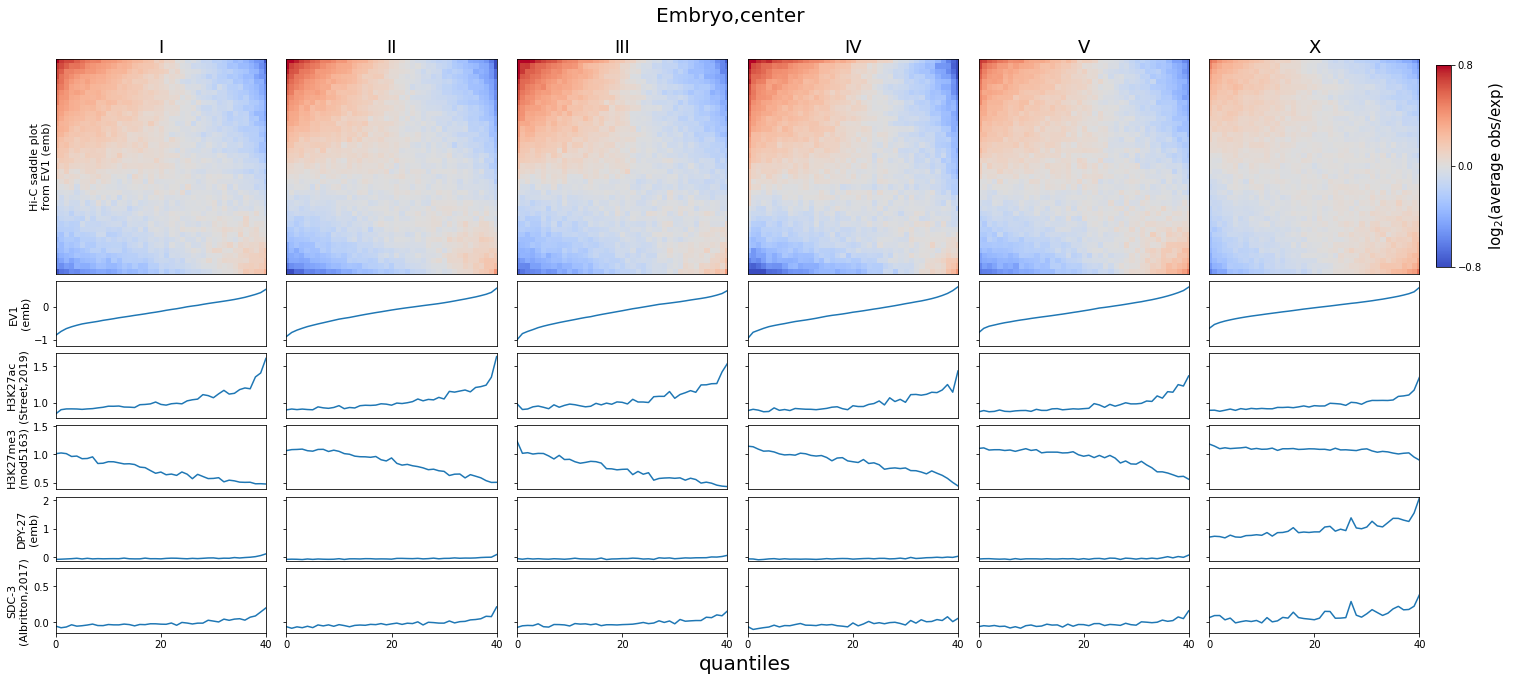

In [10]:
# embryo per chromosome, center
f, axs = plt.subplots(
    figsize=(20, 10),
    nrows=1,
    ncols=6,
    sharex=False,
    sharey='row'
)

dat = eig_emb_center
minmax = eig_minmax_emb

sub_titles = ['I','II','III','IV','V','X']
sub_titles_fontsize = 18
row_labels_common = ['Hi-C saddle plot','EV1','H3K27ac','H3K27me3','DPY-27','SDC-3']
row_labels_detail = ['\nfrom EV1 (emb)','\n(emb)','\n(Street,2019)','\n(mod5163)','\n(emb)','\n(Albritton,2017)']
row_labels = [a+b for a,b in zip(row_labels_common,row_labels_detail)]
row_labels_fontsize = 11

sMin,sMax = [-0.8,0.8]

padv = 0.05

for i in range(len(dat[0])):
    
    ##### saddle plot ####
    ax = axs[i]
    im = ax.matshow(np.log2(dat[0][i]),
              cmap='coolwarm',vmin=sMin,vmax=sMax)
    ax.xaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_title(sub_titles[i],fontsize=sub_titles_fontsize)
    if i == 0:
        ax.set(ylabel=row_labels[0])
        ax.yaxis.label.set_size(row_labels_fontsize)
    else:
        ax.axes.get_yaxis().set_ticklabels([])
    
    divider = make_axes_locatable(ax)
    xval = np.array(range(len(dat[0][i])))

    #### quantiled tracks ####
    for j in range(len(dat[1][i])):
        ax = divider.append_axes("bottom", size="30%", pad=0.1,sharex=ax)
        ax.plot(xval,dat[1][i][j][1:-1])
        ax.set_ylim([minmax[j][0]-padv,minmax[j][1]+padv])
        plt.xlim([xval.min(), xval.max()])
        if i == 0:
            ax.set(ylabel=row_labels[j+1])
            ax.yaxis.label.set_size(row_labels_fontsize)
        else:
            ax.axes.get_yaxis().set_ticklabels([])
        if j < (len(dat[1][i])-1):
            ax.xaxis.set_visible(False)
        else:
            ax.axes.set_xticks([xval.min(),xval.max()//2,xval.max()])

f.text(0.52, 0.05, 'quantiles', ha='center',fontsize=20)
cbaxes = f.add_axes([1.000001, .61, 0.01, 0.28]) 
cbar = plt.colorbar(im, cax = cbaxes, ticks=[sMin,0,sMax])
cbar.ax.get_yaxis().labelpad = 5
cbar.ax.set_ylabel('$\log_{2}$(average obs/exp)', rotation=90,fontsize=15)

f.text(0.51, 0.95, 'Embryo,center', ha='center',fontsize=20)

plt.tight_layout()


In [11]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig1s_saddle_emb_perchr_center_2kbHiC.pdf',dpi=800,bbox_inches='tight')

<ipython-input-13-68f46073bf59>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


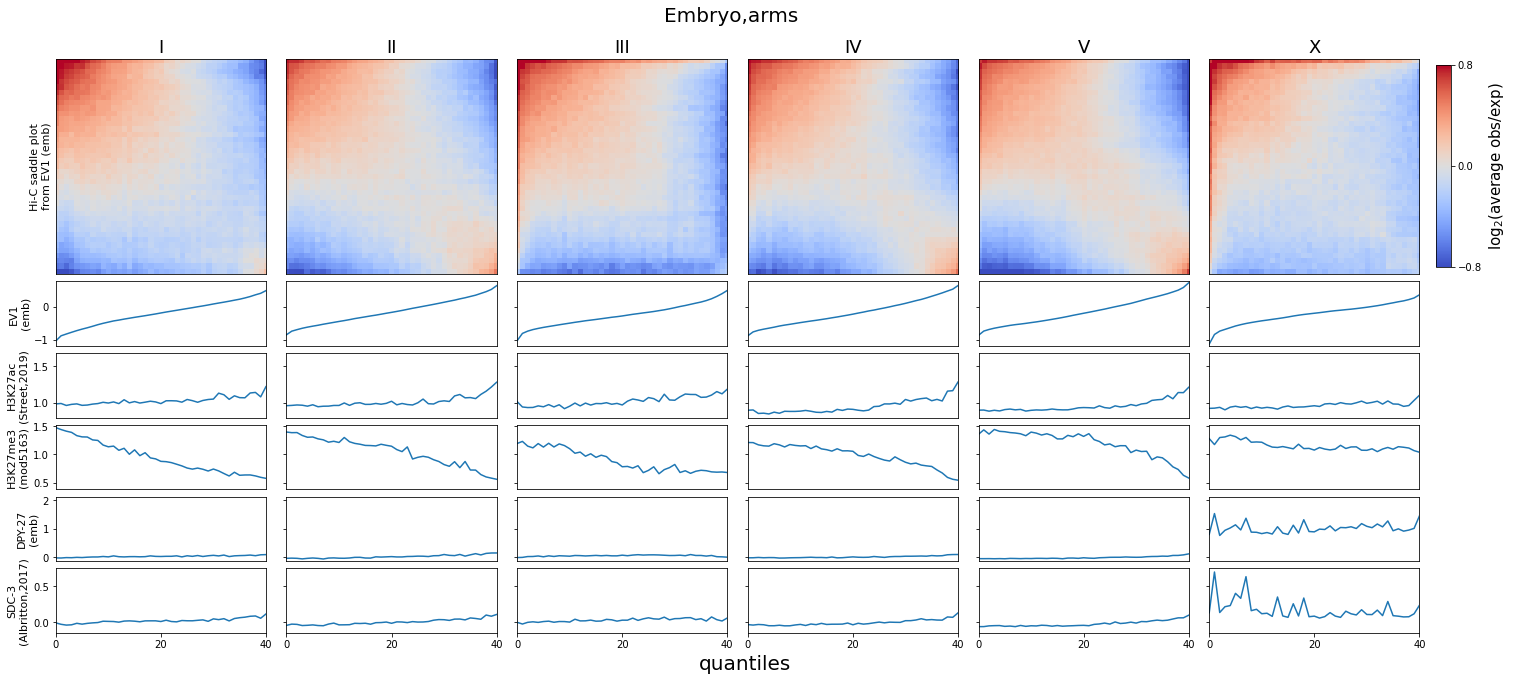

In [13]:
# embryo per chromosome, arms
f, axs = plt.subplots(
    figsize=(20, 10),
    nrows=1,
    ncols=6,
    sharex=False,
    sharey='row'
)
dat = eig_emb_arms
minmax = eig_minmax_emb

sub_titles = ['I','II','III','IV','V','X']
sub_titles_fontsize = 18
row_labels_common = ['Hi-C saddle plot','EV1','H3K27ac','H3K27me3','DPY-27','SDC-3']
row_labels_detail = ['\nfrom EV1 (emb)','\n(emb)','\n(Street,2019)','\n(mod5163)','\n(emb)','\n(Albritton,2017)']
row_labels = [a+b for a,b in zip(row_labels_common,row_labels_detail)]
row_labels_fontsize = 11

sMin,sMax = [-0.8,0.8]

padv = 0.05

for i in range(len(dat[0])):
    
    ##### saddle plot ####
    ax = axs[i]
    im = ax.matshow(np.log2(dat[0][i]),
              cmap='coolwarm',vmin=sMin,vmax=sMax)
    ax.xaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_title(sub_titles[i],fontsize=sub_titles_fontsize)
    if i == 0:
        ax.set(ylabel=row_labels[0])
        ax.yaxis.label.set_size(row_labels_fontsize)
    else:
        ax.axes.get_yaxis().set_ticklabels([])
    
    divider = make_axes_locatable(ax)
    xval = np.array(range(len(dat[0][i])))

    #### quantiled tracks ####
    for j in range(len(dat[1][i])):
        ax = divider.append_axes("bottom", size="30%", pad=0.1,sharex=ax)
        ax.plot(xval,dat[1][i][j][1:-1])
        ax.set_ylim([minmax[j][0]-padv,minmax[j][1]+padv])
        plt.xlim([xval.min(), xval.max()])
        if i == 0:
            ax.set(ylabel=row_labels[j+1])
            ax.yaxis.label.set_size(row_labels_fontsize)
        else:
            ax.axes.get_yaxis().set_ticklabels([])
        if j < (len(dat[1][i])-1):
            ax.xaxis.set_visible(False)
        else:
            ax.axes.set_xticks([xval.min(),xval.max()//2,xval.max()])

f.text(0.52, 0.05, 'quantiles', ha='center',fontsize=20)
cbaxes = f.add_axes([1.000001, .61, 0.01, 0.28]) 
cbar = plt.colorbar(im, cax = cbaxes, ticks=[sMin,0,sMax])
cbar.ax.get_yaxis().labelpad = 5
cbar.ax.set_ylabel('$\log_{2}$(average obs/exp)', rotation=90,fontsize=15)

f.text(0.51, 0.95, 'Embryo,arms', ha='center',fontsize=20)

plt.tight_layout()


In [14]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig1s_saddle_emb_perchr_arms_2kbHiC.pdf',dpi=800,bbox_inches='tight')

<ipython-input-15-ff96cb86e8c2>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


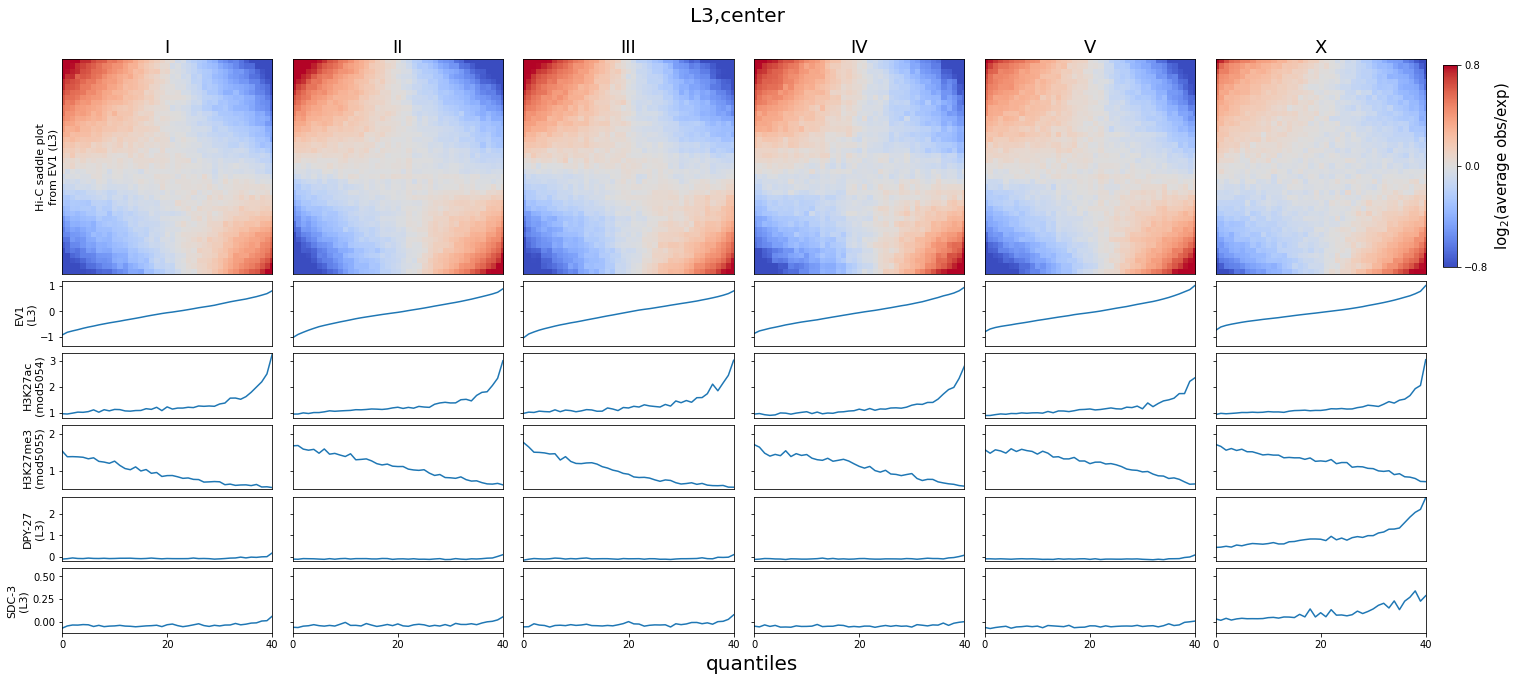

In [15]:
# L3 per chromosome, center
f, axs = plt.subplots(
    figsize=(20, 10),
    nrows=1,
    ncols=6,
    sharex=False,
    sharey='row'
)

dat = eig_L3_center
minmax = eig_minmax_L3

sub_titles = ['I','II','III','IV','V','X']
sub_titles_fontsize = 18

row_labels_common = ['Hi-C saddle plot','EV1','H3K27ac','H3K27me3','DPY-27','SDC-3']
row_labels_detail = ['\nfrom EV1 (L3)','\n(L3)','\n(mod5054)','\n(mod5055)','\n(L3)','\n(L3)']
row_labels = [a+b for a,b in zip(row_labels_common,row_labels_detail)]
row_labels_fontsize = 11

sMin,sMax = [-0.8,0.8]

padv = 0.05

for i in range(len(dat[0])):
    
    ##### saddle plot ####
    ax = axs[i]
    im = ax.matshow(np.log2(dat[0][i]),
              cmap='coolwarm',vmin=sMin,vmax=sMax)
    ax.xaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_title(sub_titles[i],fontsize=sub_titles_fontsize)
    if i == 0:
        ax.set(ylabel=row_labels[0])
        ax.yaxis.label.set_size(row_labels_fontsize)
    else:
        ax.axes.get_yaxis().set_ticklabels([])
    
    divider = make_axes_locatable(ax)
    xval = np.array(range(len(dat[0][i])))

    #### quantiled tracks ####
    for j in range(len(dat[1][i])):
        ax = divider.append_axes("bottom", size="30%", pad=0.1,sharex=ax)
        ax.plot(xval,dat[1][i][j][1:-1])
        ax.set_ylim([minmax[j][0]-padv,minmax[j][1]+padv])
        plt.xlim([xval.min(), xval.max()])
        if i == 0:
            ax.set(ylabel=row_labels[j+1])
            ax.yaxis.label.set_size(row_labels_fontsize)
        else:
            ax.axes.get_yaxis().set_ticklabels([])
        if j < (len(dat[1][i])-1):
            ax.xaxis.set_visible(False)
        else:
            ax.axes.set_xticks([xval.min(),xval.max()//2,xval.max()])

f.text(0.52, 0.05, 'quantiles', ha='center',fontsize=20)
cbaxes = f.add_axes([1.000001, .61, 0.01, 0.28]) 
cbar = plt.colorbar(im, cax = cbaxes, ticks=[sMin,0,sMax])
cbar.ax.get_yaxis().labelpad = 5
cbar.ax.set_ylabel('$\log_{2}$(average obs/exp)', rotation=90,fontsize=15)

f.text(0.51, 0.95, 'L3,center', ha='center',fontsize=20)

plt.tight_layout()

In [16]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig1s_saddle_L3_perchr_center_2kbHiC.pdf',dpi=800,bbox_inches='tight')

<ipython-input-17-2a5f92b2a03f>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


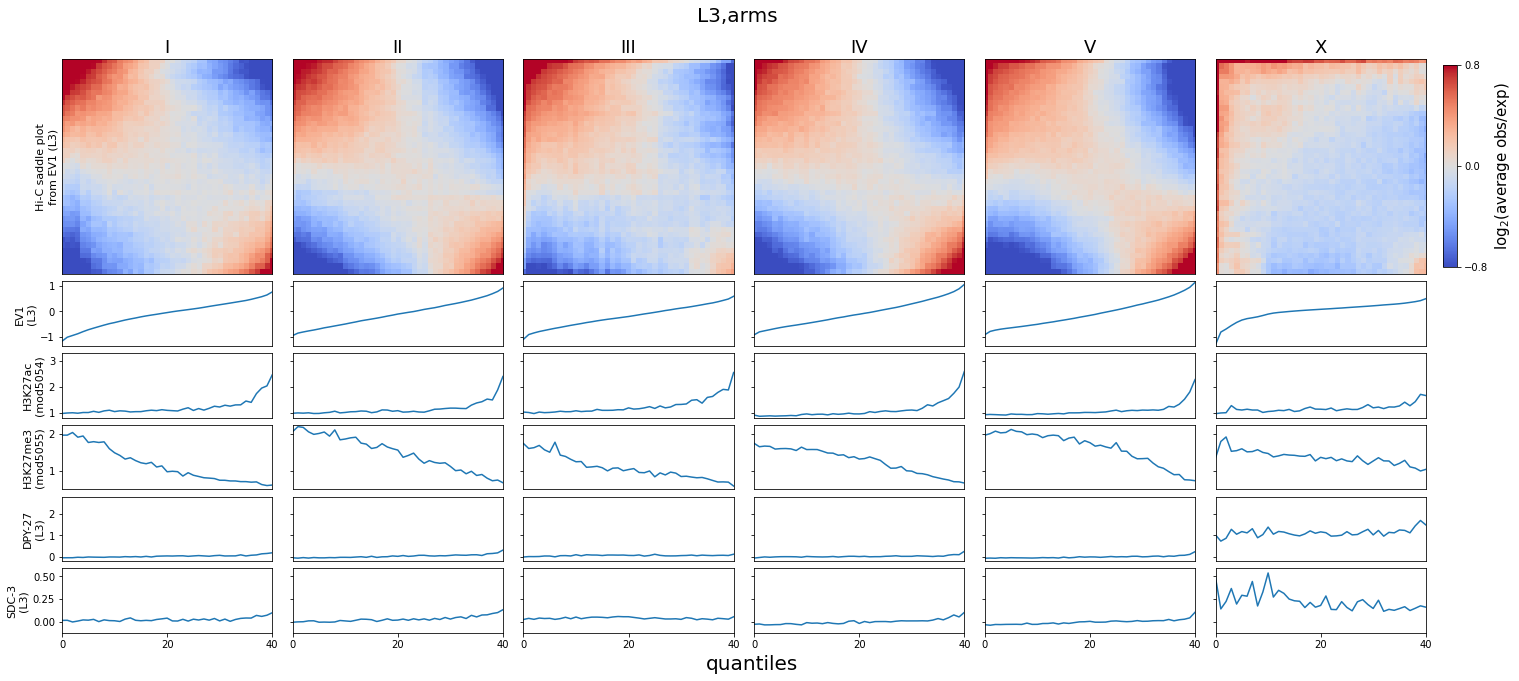

In [17]:
# L3 per chromosome, arms
f, axs = plt.subplots(
    figsize=(20, 10),
    nrows=1,
    ncols=6,
    sharex=False,
    sharey='row'
)

dat = eig_L3_arms
minmax = eig_minmax_L3

sub_titles = ['I','II','III','IV','V','X']
sub_titles_fontsize = 18

row_labels_common = ['Hi-C saddle plot','EV1','H3K27ac','H3K27me3','DPY-27','SDC-3']
row_labels_detail = ['\nfrom EV1 (L3)','\n(L3)','\n(mod5054)','\n(mod5055)','\n(L3)','\n(L3)']
row_labels = [a+b for a,b in zip(row_labels_common,row_labels_detail)]
row_labels_fontsize = 11

sMin,sMax = [-0.8,0.8]

padv = 0.05

for i in range(len(dat[0])):
    
    ##### saddle plot ####
    ax = axs[i]
    im = ax.matshow(np.log2(dat[0][i]),
              cmap='coolwarm',vmin=sMin,vmax=sMax)
    ax.xaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_title(sub_titles[i],fontsize=sub_titles_fontsize)
    if i == 0:
        ax.set(ylabel=row_labels[0])
        ax.yaxis.label.set_size(row_labels_fontsize)
    else:
        ax.axes.get_yaxis().set_ticklabels([])
    
    divider = make_axes_locatable(ax)
    xval = np.array(range(len(dat[0][i])))

    #### quantiled tracks ####
    for j in range(len(dat[1][i])):
        ax = divider.append_axes("bottom", size="30%", pad=0.1,sharex=ax)
        ax.plot(xval,dat[1][i][j][1:-1])
        ax.set_ylim([minmax[j][0]-padv,minmax[j][1]+padv])
        plt.xlim([xval.min(), xval.max()])
        if i == 0:
            ax.set(ylabel=row_labels[j+1])
            ax.yaxis.label.set_size(row_labels_fontsize)
        else:
            ax.axes.get_yaxis().set_ticklabels([])
        if j < (len(dat[1][i])-1):
            ax.xaxis.set_visible(False)
        else:
            ax.axes.set_xticks([xval.min(),xval.max()//2,xval.max()])

f.text(0.52, 0.05, 'quantiles', ha='center',fontsize=20)
cbaxes = f.add_axes([1.000001, .61, 0.01, 0.28]) 
cbar = plt.colorbar(im, cax = cbaxes, ticks=[sMin,0,sMax])
cbar.ax.get_yaxis().labelpad = 5
cbar.ax.set_ylabel('$\log_{2}$(average obs/exp)', rotation=90,fontsize=15)

f.text(0.51, 0.95, 'L3,arms', ha='center',fontsize=20)

plt.tight_layout()

In [18]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig1s_saddle_L3_perchr_arms_2kbHiC.pdf',dpi=800,bbox_inches='tight')

<ipython-input-19-e230785f166e>:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


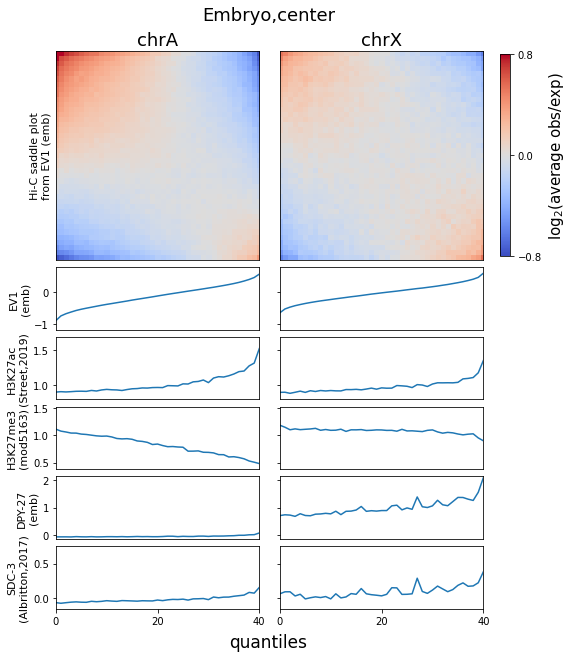

In [19]:
############################### saddle plot autosome averaged, embryo ############
f, axs = plt.subplots(
    figsize=(7, 10),
    nrows=1,
    ncols=2,
    sharex=False,
    sharey='row'
)
dat = eig_emb_center_combinedA
minmax = eig_minmax_emb

f.text(0.54, 0.93, 'Embryo,center', ha='center',fontsize=18)

sub_titles = ['chrA','chrX']
sub_titles_fontsize = 18
row_labels_common = ['Hi-C saddle plot','EV1','H3K27ac','H3K27me3','DPY-27','SDC-3']
row_labels_detail = ['\nfrom EV1 (emb)','\n(emb)','\n(Street,2019)','\n(mod5163)','\n(emb)','\n(Albritton,2017)']

row_labels = [a+b for a,b in zip(row_labels_common,row_labels_detail)]
row_labels_fontsize = 11

sMin,sMax = [-0.8,0.8]

padv = 0.05

for i in range(len(dat)):
    
    ##### saddle plot ####
    ax = axs[i]
    im = ax.matshow(np.log2(dat[i][0]),
              cmap='coolwarm',vmin=sMin,vmax=sMax)
    ax.xaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_title(sub_titles[i],fontsize=sub_titles_fontsize)
    if i == 0:
        ax.set(ylabel=row_labels[0])
        ax.yaxis.label.set_size(row_labels_fontsize)
    else:
        ax.axes.get_yaxis().set_ticklabels([])
    divider = make_axes_locatable(ax)
    xval = np.array(range(len(dat[i][0])))

    #####  ####
    for j in range(len(dat[i][1])):
        ax = divider.append_axes("bottom", size="30%", pad=0.1,sharex=ax)
        ax.plot(xval,dat[i][1][j][1:-1])
        ax.set_ylim([minmax[j][0]-padv,minmax[j][1]+padv])
        plt.xlim([xval.min(), xval.max()])
        if i == 0:
            ax.set(ylabel=row_labels[j+1])
            ax.yaxis.label.set_size(row_labels_fontsize)
        else:
            ax.axes.get_yaxis().set_ticklabels([])
        if j < (len(dat[i][1])-1):
            ax.xaxis.set_visible(False)
        else:
            ax.axes.set_xticks([xval.min(),xval.max()//2,xval.max()])

    

f.text(0.54, 0.06, 'quantiles', ha='center',fontsize=17)
cbaxes = f.add_axes([1.00001, .603, 0.02, 0.28]) 
cbar = plt.colorbar(im, cax = cbaxes, ticks=[sMin,0,sMax])
cbar.ax.get_yaxis().labelpad = 5
cbar.ax.set_ylabel('$\log_{2}$(average obs/exp)', rotation=90,fontsize=15)



plt.tight_layout()

In [20]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig1_saddle_emb_2kbHiC.pdf',dpi=800,bbox_inches='tight')

<ipython-input-21-5d9d88814eda>:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


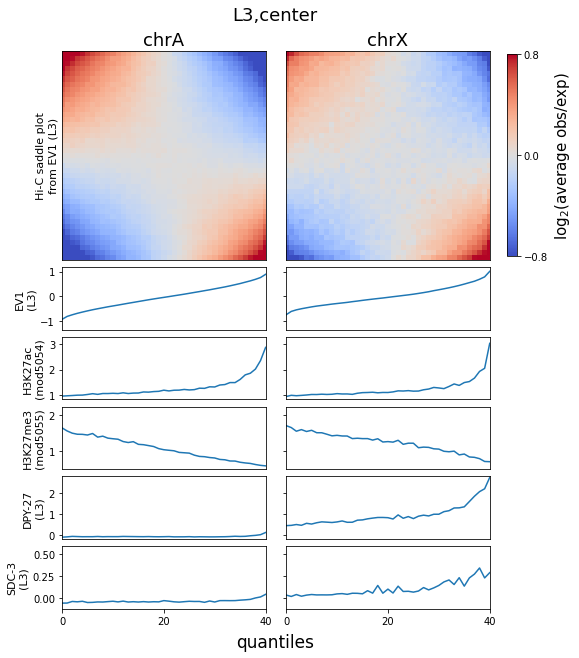

In [21]:
############################### saddle plot autosome averaged, embryo ############
f, axs = plt.subplots(
    figsize=(7, 10),
    nrows=1,
    ncols=2,
    sharex=False,
    sharey='row'
)
dat = eig_L3_center_combinedA
minmax = eig_minmax_L3

f.text(0.54, 0.93, 'L3,center', ha='center',fontsize=18)

sub_titles = ['chrA','chrX']
sub_titles_fontsize = 18
row_labels_common = ['Hi-C saddle plot','EV1','H3K27ac','H3K27me3','DPY-27','SDC-3']
row_labels_detail = ['\nfrom EV1 (L3)','\n(L3)','\n(mod5054)','\n(mod5055)','\n(L3)','\n(L3)']
row_labels = [a+b for a,b in zip(row_labels_common,row_labels_detail)]
row_labels_fontsize = 11

sMin,sMax = [-0.8,0.8]

padv = 0.05

for i in range(len(dat)):
    
    ##### saddle plot ####
    ax = axs[i]
    im = ax.matshow(np.log2(dat[i][0]),
              cmap='coolwarm',vmin=sMin,vmax=sMax)
    ax.xaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_title(sub_titles[i],fontsize=sub_titles_fontsize)
    if i == 0:
        ax.set(ylabel=row_labels[0])
        ax.yaxis.label.set_size(row_labels_fontsize)
    else:
        ax.axes.get_yaxis().set_ticklabels([])
    divider = make_axes_locatable(ax)
    xval = np.array(range(len(dat[i][0])))

    #####  ####
    for j in range(len(dat[i][1])):
        ax = divider.append_axes("bottom", size="30%", pad=0.1,sharex=ax)
        ax.plot(xval,dat[i][1][j][1:-1])
        ax.set_ylim([minmax[j][0]-padv,minmax[j][1]+padv])
        plt.xlim([xval.min(), xval.max()])
        if i == 0:
            ax.set(ylabel=row_labels[j+1])
            ax.yaxis.label.set_size(row_labels_fontsize)
        else:
            ax.axes.get_yaxis().set_ticklabels([])
        if j < (len(dat[i][1])-1):
            ax.xaxis.set_visible(False)
        else:
            ax.axes.set_xticks([xval.min(),xval.max()//2,xval.max()])

    

f.text(0.54, 0.06, 'quantiles', ha='center',fontsize=17)
cbaxes = f.add_axes([1.00001, .603, 0.02, 0.28]) 
cbar = plt.colorbar(im, cax = cbaxes, ticks=[sMin,0,sMax])
cbar.ax.get_yaxis().labelpad = 5
cbar.ax.set_ylabel('$\log_{2}$(average obs/exp)', rotation=90,fontsize=15)



plt.tight_layout()

In [22]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig1_saddle_L3_2kbHiC.pdf',dpi=800,bbox_inches='tight')

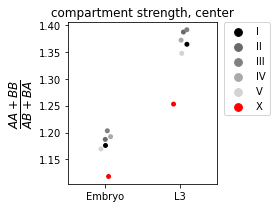

In [33]:
### comp score, center
f, axs = plt.subplots(
    figsize=(4, 3),
    nrows=1,
    ncols=1,
    sharey='row'
)

colors = ['black','dimgrey','grey','darkgrey','lightgrey','red']

a = sns.stripplot(data=COMP_center,x='stage', y='COMP',hue='chr',palette=colors)
a.get_legend().remove()
a.set_title('compartment strength, center')

a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
a.set_ylabel(r"$\frac{AA + BB}{AB + BA}$" ,rotation=90,fontsize=17,labelpad=4)
a.set_xlabel('')

plt.tight_layout()

In [34]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig1_COMP_center_HiC2kb.pdf',dpi=800,bbox_inches='tight')

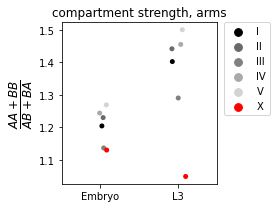

In [35]:
### comp score, arms
f, axs = plt.subplots(
    figsize=(4, 3),
    nrows=1,
    ncols=1,
    sharey='row'
)

colors = ['black','dimgrey','grey','darkgrey','lightgrey','red']

a = sns.stripplot(data=COMP_arms,x='stage', y='COMP',hue='chr',palette=colors)
a.get_legend().remove()
a.set_title('compartment strength, arms')
a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
a.set_ylabel(r"$\frac{AA + BB}{AB + BA}$" ,rotation=90,fontsize=17,labelpad=4)
a.set_xlabel('')

plt.tight_layout()

In [36]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig1s_COMP_arms_HiC2kb.pdf',dpi=800,bbox_inches='tight')

In [5]:
def make_sliders(bed,stepSize,nSteps,LorR):
    a = list()
    b = list()
    c = list()
    chrom = bed['chrom'][0]
    for i in range(nSteps):
        if LorR == 'L':
            a_i = bed['start']-(i)*stepSize
            b_i = bed['end']-(i)*stepSize
        if LorR == 'R':
            a_i = bed['start']+(i)*stepSize
            b_i = bed['end']+(i)*stepSize
        a.append(int(a_i))
        b.append(int(b_i))
        c.append(chrom)
    x = pd.DataFrame({'chrom': c,'start': a,'end': b})
    return(x)

import time

def slider_Saddle_COMP(clr,slider_lst,q,activeTrk):
    ti = time.time()
    output = []
    for s in range(len(slider_lst)):
        print('slider_lst_element ' + str(s))
        saddle_s = []
        COMP_s = []
        for i in range(len(slider_lst[s])):
            print(slider_lst[s].loc[[i]])
            x = eigdecomp_saddle(clr,slider_lst[s].loc[[i]].reset_index(drop=True),q,activeTrk)
            a = x[3]/x[4]
            b = np.delete(a, (0,len(a)-1), axis=0)
            c = np.delete(b, (0,len(a)-1), axis=1)
            d = compute_COMP(c)
            saddle_s.append(c)
            COMP_s.append(d)
        output.append([saddle_s,COMP_s])
    tf = time.time()
    print(tf-ti)
    return(output)

########################### alternative COMP computing: sliding window ###############################

ce10_end = bioframe.read_table('/home/kimj50/ce10.chrom.sizes',schema='bed3')['end']
all_2mb = bioframe.read_table('ce10_sub/all_2mb.bed',schema='bed3')

windowSize = 2_000_000
stepSize = 200_000
maxn = (ce10_end-windowSize)//stepSize

all_slider_lst = []
for i in range(6):
    x = make_sliders(all_2mb.iloc[[i]].reset_index(drop=True),200000,maxn[i],'R')
    x = bioframe.parse_regions(x)
    all_slider_lst.append(x)

all_slider_lst[5]

,chrom,start,end,name
0,X,0,2000000,X:0-2000000
1,X,200000,2200000,X:200000-2200000
2,X,400000,2400000,X:400000-2400000
3,X,600000,2600000,X:600000-2600000
4,X,800000,2800000,X:800000-2800000
...,...,...,...,...
73,X,14600000,16600000,X:14600000-16600000
74,X,14800000,16800000,X:14800000-16800000
75,X,15000000,17000000,X:15000000-17000000
76,X,15200000,17200000,X:15200000-17200000


In [6]:
#COMP_sliders_emb = slider_Saddle_COMP(clr_emb,all_slider_lst,25,active_track_emb)
#COMP_sliders_L3 = slider_Saddle_COMP(clr_L3,all_slider_lst,25,active_track_L3)


slider_lst_element 0
  chrom  start      end         name
0     I      0  2000000  I:0-2000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end              name
1     I  200000  2200000  I:200000-2200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end              name
2     I  400000  2400000  I:400000-2400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end              name
3     I  600000  2600000  I:600000-2600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end              name
4     I  800000  2800000  I:800000-2800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end               name
5     I  1000000  3000000  I:1000000-3000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end               name
6     I  1200000  3200000  I:1200000-3200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end               name
7     I  1400000  3400000  I:1400000-3400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end               name
8     I  1600000  3600000  I:1600000-3600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end               name
9     I  1800000  3800000  I:1800000-3800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
10     I  2000000  4000000  I:2000000-4000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
11     I  2200000  4200000  I:2200000-4200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
12     I  2400000  4400000  I:2400000-4400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
13     I  2600000  4600000  I:2600000-4600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
14     I  2800000  4800000  I:2800000-4800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
15     I  3000000  5000000  I:3000000-5000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
16     I  3200000  5200000  I:3200000-5200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
17     I  3400000  5400000  I:3400000-5400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
18     I  3600000  5600000  I:3600000-5600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
19     I  3800000  5800000  I:3800000-5800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
20     I  4000000  6000000  I:4000000-6000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
21     I  4200000  6200000  I:4200000-6200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
22     I  4400000  6400000  I:4400000-6400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
23     I  4600000  6600000  I:4600000-6600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
24     I  4800000  6800000  I:4800000-6800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
25     I  5000000  7000000  I:5000000-7000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
26     I  5200000  7200000  I:5200000-7200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
27     I  5400000  7400000  I:5400000-7400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
28     I  5600000  7600000  I:5600000-7600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
29     I  5800000  7800000  I:5800000-7800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
30     I  6000000  8000000  I:6000000-8000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
31     I  6200000  8200000  I:6200000-8200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
32     I  6400000  8400000  I:6400000-8400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
33     I  6600000  8600000  I:6600000-8600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
34     I  6800000  8800000  I:6800000-8800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
35     I  7000000  9000000  I:7000000-9000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
36     I  7200000  9200000  I:7200000-9200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
37     I  7400000  9400000  I:7400000-9400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
38     I  7600000  9600000  I:7600000-9600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
39     I  7800000  9800000  I:7800000-9800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
40     I  8000000  10000000  I:8000000-10000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
41     I  8200000  10200000  I:8200000-10200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
42     I  8400000  10400000  I:8400000-10400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
43     I  8600000  10600000  I:8600000-10600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
44     I  8800000  10800000  I:8800000-10800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
45     I  9000000  11000000  I:9000000-11000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
46     I  9200000  11200000  I:9200000-11200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
47     I  9400000  11400000  I:9400000-11400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
48     I  9600000  11600000  I:9600000-11600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
49     I  9800000  11800000  I:9800000-11800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
50     I  10000000  12000000  I:10000000-12000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
51     I  10200000  12200000  I:10200000-12200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
52     I  10400000  12400000  I:10400000-12400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
53     I  10600000  12600000  I:10600000-12600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
54     I  10800000  12800000  I:10800000-12800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
55     I  11000000  13000000  I:11000000-13000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
56     I  11200000  13200000  I:11200000-13200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
57     I  11400000  13400000  I:11400000-13400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
58     I  11600000  13600000  I:11600000-13600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
59     I  11800000  13800000  I:11800000-13800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
60     I  12000000  14000000  I:12000000-14000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
61     I  12200000  14200000  I:12200000-14200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
62     I  12400000  14400000  I:12400000-14400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
63     I  12600000  14600000  I:12600000-14600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
64     I  12800000  14800000  I:12800000-14800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


slider_lst_element 1
  chrom  start      end          name
0    II      0  2000000  II:0-2000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end               name
1    II  200000  2200000  II:200000-2200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end               name
2    II  400000  2400000  II:400000-2400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end               name
3    II  600000  2600000  II:600000-2600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end               name
4    II  800000  2800000  II:800000-2800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end                name
5    II  1000000  3000000  II:1000000-3000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end                name
6    II  1200000  3200000  II:1200000-3200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end                name
7    II  1400000  3400000  II:1400000-3400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end                name
8    II  1600000  3600000  II:1600000-3600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end                name
9    II  1800000  3800000  II:1800000-3800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
10    II  2000000  4000000  II:2000000-4000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
11    II  2200000  4200000  II:2200000-4200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
12    II  2400000  4400000  II:2400000-4400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
13    II  2600000  4600000  II:2600000-4600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
14    II  2800000  4800000  II:2800000-4800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
15    II  3000000  5000000  II:3000000-5000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
16    II  3200000  5200000  II:3200000-5200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
17    II  3400000  5400000  II:3400000-5400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
18    II  3600000  5600000  II:3600000-5600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
19    II  3800000  5800000  II:3800000-5800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
20    II  4000000  6000000  II:4000000-6000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
21    II  4200000  6200000  II:4200000-6200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
22    II  4400000  6400000  II:4400000-6400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
23    II  4600000  6600000  II:4600000-6600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
24    II  4800000  6800000  II:4800000-6800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
25    II  5000000  7000000  II:5000000-7000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
26    II  5200000  7200000  II:5200000-7200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
27    II  5400000  7400000  II:5400000-7400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
28    II  5600000  7600000  II:5600000-7600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
29    II  5800000  7800000  II:5800000-7800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
30    II  6000000  8000000  II:6000000-8000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
31    II  6200000  8200000  II:6200000-8200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
32    II  6400000  8400000  II:6400000-8400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
33    II  6600000  8600000  II:6600000-8600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
34    II  6800000  8800000  II:6800000-8800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
35    II  7000000  9000000  II:7000000-9000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
36    II  7200000  9200000  II:7200000-9200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
37    II  7400000  9400000  II:7400000-9400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
38    II  7600000  9600000  II:7600000-9600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
39    II  7800000  9800000  II:7800000-9800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                 name
40    II  8000000  10000000  II:8000000-10000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                 name
41    II  8200000  10200000  II:8200000-10200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                 name
42    II  8400000  10400000  II:8400000-10400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                 name
43    II  8600000  10600000  II:8600000-10600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                 name
44    II  8800000  10800000  II:8800000-10800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                 name
45    II  9000000  11000000  II:9000000-11000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                 name
46    II  9200000  11200000  II:9200000-11200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                 name
47    II  9400000  11400000  II:9400000-11400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                 name
48    II  9600000  11600000  II:9600000-11600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                 name
49    II  9800000  11800000  II:9800000-11800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
50    II  10000000  12000000  II:10000000-12000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
51    II  10200000  12200000  II:10200000-12200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
52    II  10400000  12400000  II:10400000-12400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
53    II  10600000  12600000  II:10600000-12600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
54    II  10800000  12800000  II:10800000-12800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
55    II  11000000  13000000  II:11000000-13000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
56    II  11200000  13200000  II:11200000-13200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
57    II  11400000  13400000  II:11400000-13400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
58    II  11600000  13600000  II:11600000-13600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
59    II  11800000  13800000  II:11800000-13800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
60    II  12000000  14000000  II:12000000-14000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
61    II  12200000  14200000  II:12200000-14200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
62    II  12400000  14400000  II:12400000-14400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
63    II  12600000  14600000  II:12600000-14600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
64    II  12800000  14800000  II:12800000-14800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
65    II  13000000  15000000  II:13000000-15000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


slider_lst_element 2
  chrom  start      end           name
0   III      0  2000000  III:0-2000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end                name
1   III  200000  2200000  III:200000-2200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end                name
2   III  400000  2400000  III:400000-2400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end                name
3   III  600000  2600000  III:600000-2600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end                name
4   III  800000  2800000  III:800000-2800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end                 name
5   III  1000000  3000000  III:1000000-3000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end                 name
6   III  1200000  3200000  III:1200000-3200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end                 name
7   III  1400000  3400000  III:1400000-3400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end                 name
8   III  1600000  3600000  III:1600000-3600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end                 name
9   III  1800000  3800000  III:1800000-3800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
10   III  2000000  4000000  III:2000000-4000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
11   III  2200000  4200000  III:2200000-4200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
12   III  2400000  4400000  III:2400000-4400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
13   III  2600000  4600000  III:2600000-4600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
14   III  2800000  4800000  III:2800000-4800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
15   III  3000000  5000000  III:3000000-5000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
16   III  3200000  5200000  III:3200000-5200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
17   III  3400000  5400000  III:3400000-5400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
18   III  3600000  5600000  III:3600000-5600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
19   III  3800000  5800000  III:3800000-5800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
20   III  4000000  6000000  III:4000000-6000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
21   III  4200000  6200000  III:4200000-6200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
22   III  4400000  6400000  III:4400000-6400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
23   III  4600000  6600000  III:4600000-6600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
24   III  4800000  6800000  III:4800000-6800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
25   III  5000000  7000000  III:5000000-7000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
26   III  5200000  7200000  III:5200000-7200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
27   III  5400000  7400000  III:5400000-7400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
28   III  5600000  7600000  III:5600000-7600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
29   III  5800000  7800000  III:5800000-7800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
30   III  6000000  8000000  III:6000000-8000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
31   III  6200000  8200000  III:6200000-8200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
32   III  6400000  8400000  III:6400000-8400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
33   III  6600000  8600000  III:6600000-8600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
34   III  6800000  8800000  III:6800000-8800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
35   III  7000000  9000000  III:7000000-9000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
36   III  7200000  9200000  III:7200000-9200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
37   III  7400000  9400000  III:7400000-9400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
38   III  7600000  9600000  III:7600000-9600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                 name
39   III  7800000  9800000  III:7800000-9800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                  name
40   III  8000000  10000000  III:8000000-10000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                  name
41   III  8200000  10200000  III:8200000-10200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                  name
42   III  8400000  10400000  III:8400000-10400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                  name
43   III  8600000  10600000  III:8600000-10600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                  name
44   III  8800000  10800000  III:8800000-10800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                  name
45   III  9000000  11000000  III:9000000-11000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                  name
46   III  9200000  11200000  III:9200000-11200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                  name
47   III  9400000  11400000  III:9400000-11400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                  name
48   III  9600000  11600000  III:9600000-11600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                  name
49   III  9800000  11800000  III:9800000-11800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                   name
50   III  10000000  12000000  III:10000000-12000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                   name
51   III  10200000  12200000  III:10200000-12200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                   name
52   III  10400000  12400000  III:10400000-12400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                   name
53   III  10600000  12600000  III:10600000-12600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                   name
54   III  10800000  12800000  III:10800000-12800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                   name
55   III  11000000  13000000  III:11000000-13000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                   name
56   III  11200000  13200000  III:11200000-13200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                   name
57   III  11400000  13400000  III:11400000-13400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


slider_lst_element 3
  chrom  start      end          name
0    IV      0  2000000  IV:0-2000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end               name
1    IV  200000  2200000  IV:200000-2200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end               name
2    IV  400000  2400000  IV:400000-2400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end               name
3    IV  600000  2600000  IV:600000-2600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end               name
4    IV  800000  2800000  IV:800000-2800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end                name
5    IV  1000000  3000000  IV:1000000-3000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end                name
6    IV  1200000  3200000  IV:1200000-3200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end                name
7    IV  1400000  3400000  IV:1400000-3400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end                name
8    IV  1600000  3600000  IV:1600000-3600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end                name
9    IV  1800000  3800000  IV:1800000-3800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
10    IV  2000000  4000000  IV:2000000-4000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
11    IV  2200000  4200000  IV:2200000-4200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
12    IV  2400000  4400000  IV:2400000-4400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
13    IV  2600000  4600000  IV:2600000-4600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
14    IV  2800000  4800000  IV:2800000-4800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
15    IV  3000000  5000000  IV:3000000-5000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
16    IV  3200000  5200000  IV:3200000-5200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
17    IV  3400000  5400000  IV:3400000-5400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
18    IV  3600000  5600000  IV:3600000-5600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
19    IV  3800000  5800000  IV:3800000-5800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
20    IV  4000000  6000000  IV:4000000-6000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
21    IV  4200000  6200000  IV:4200000-6200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
22    IV  4400000  6400000  IV:4400000-6400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
23    IV  4600000  6600000  IV:4600000-6600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
24    IV  4800000  6800000  IV:4800000-6800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
25    IV  5000000  7000000  IV:5000000-7000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
26    IV  5200000  7200000  IV:5200000-7200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
27    IV  5400000  7400000  IV:5400000-7400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
28    IV  5600000  7600000  IV:5600000-7600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
29    IV  5800000  7800000  IV:5800000-7800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
30    IV  6000000  8000000  IV:6000000-8000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
31    IV  6200000  8200000  IV:6200000-8200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
32    IV  6400000  8400000  IV:6400000-8400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
33    IV  6600000  8600000  IV:6600000-8600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
34    IV  6800000  8800000  IV:6800000-8800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
35    IV  7000000  9000000  IV:7000000-9000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
36    IV  7200000  9200000  IV:7200000-9200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
37    IV  7400000  9400000  IV:7400000-9400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
38    IV  7600000  9600000  IV:7600000-9600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end                name
39    IV  7800000  9800000  IV:7800000-9800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                 name
40    IV  8000000  10000000  IV:8000000-10000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                 name
41    IV  8200000  10200000  IV:8200000-10200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                 name
42    IV  8400000  10400000  IV:8400000-10400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                 name
43    IV  8600000  10600000  IV:8600000-10600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                 name
44    IV  8800000  10800000  IV:8800000-10800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                 name
45    IV  9000000  11000000  IV:9000000-11000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                 name
46    IV  9200000  11200000  IV:9200000-11200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                 name
47    IV  9400000  11400000  IV:9400000-11400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                 name
48    IV  9600000  11600000  IV:9600000-11600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                 name
49    IV  9800000  11800000  IV:9800000-11800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
50    IV  10000000  12000000  IV:10000000-12000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
51    IV  10200000  12200000  IV:10200000-12200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
52    IV  10400000  12400000  IV:10400000-12400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
53    IV  10600000  12600000  IV:10600000-12600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
54    IV  10800000  12800000  IV:10800000-12800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
55    IV  11000000  13000000  IV:11000000-13000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
56    IV  11200000  13200000  IV:11200000-13200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
57    IV  11400000  13400000  IV:11400000-13400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
58    IV  11600000  13600000  IV:11600000-13600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
59    IV  11800000  13800000  IV:11800000-13800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
60    IV  12000000  14000000  IV:12000000-14000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
61    IV  12200000  14200000  IV:12200000-14200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
62    IV  12400000  14400000  IV:12400000-14400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
63    IV  12600000  14600000  IV:12600000-14600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
64    IV  12800000  14800000  IV:12800000-14800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
65    IV  13000000  15000000  IV:13000000-15000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
66    IV  13200000  15200000  IV:13200000-15200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
67    IV  13400000  15400000  IV:13400000-15400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
68    IV  13600000  15600000  IV:13600000-15600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
69    IV  13800000  15800000  IV:13800000-15800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
70    IV  14000000  16000000  IV:14000000-16000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
71    IV  14200000  16200000  IV:14200000-16200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
72    IV  14400000  16400000  IV:14400000-16400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
73    IV  14600000  16600000  IV:14600000-16600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
74    IV  14800000  16800000  IV:14800000-16800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
75    IV  15000000  17000000  IV:15000000-17000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                  name
76    IV  15200000  17200000  IV:15200000-17200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


slider_lst_element 4
  chrom  start      end         name
0     V      0  2000000  V:0-2000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end              name
1     V  200000  2200000  V:200000-2200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end              name
2     V  400000  2400000  V:400000-2400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end              name
3     V  600000  2600000  V:600000-2600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end              name
4     V  800000  2800000  V:800000-2800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end               name
5     V  1000000  3000000  V:1000000-3000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end               name
6     V  1200000  3200000  V:1200000-3200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end               name
7     V  1400000  3400000  V:1400000-3400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end               name
8     V  1600000  3600000  V:1600000-3600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end               name
9     V  1800000  3800000  V:1800000-3800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
10     V  2000000  4000000  V:2000000-4000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
11     V  2200000  4200000  V:2200000-4200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
12     V  2400000  4400000  V:2400000-4400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
13     V  2600000  4600000  V:2600000-4600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
14     V  2800000  4800000  V:2800000-4800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
15     V  3000000  5000000  V:3000000-5000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
16     V  3200000  5200000  V:3200000-5200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
17     V  3400000  5400000  V:3400000-5400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
18     V  3600000  5600000  V:3600000-5600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
19     V  3800000  5800000  V:3800000-5800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
20     V  4000000  6000000  V:4000000-6000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
21     V  4200000  6200000  V:4200000-6200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
22     V  4400000  6400000  V:4400000-6400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
23     V  4600000  6600000  V:4600000-6600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
24     V  4800000  6800000  V:4800000-6800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
25     V  5000000  7000000  V:5000000-7000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
26     V  5200000  7200000  V:5200000-7200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
27     V  5400000  7400000  V:5400000-7400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
28     V  5600000  7600000  V:5600000-7600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
29     V  5800000  7800000  V:5800000-7800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
30     V  6000000  8000000  V:6000000-8000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
31     V  6200000  8200000  V:6200000-8200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
32     V  6400000  8400000  V:6400000-8400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
33     V  6600000  8600000  V:6600000-8600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
34     V  6800000  8800000  V:6800000-8800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
35     V  7000000  9000000  V:7000000-9000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
36     V  7200000  9200000  V:7200000-9200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
37     V  7400000  9400000  V:7400000-9400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
38     V  7600000  9600000  V:7600000-9600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
39     V  7800000  9800000  V:7800000-9800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
40     V  8000000  10000000  V:8000000-10000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
41     V  8200000  10200000  V:8200000-10200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
42     V  8400000  10400000  V:8400000-10400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
43     V  8600000  10600000  V:8600000-10600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
44     V  8800000  10800000  V:8800000-10800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
45     V  9000000  11000000  V:9000000-11000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
46     V  9200000  11200000  V:9200000-11200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
47     V  9400000  11400000  V:9400000-11400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
48     V  9600000  11600000  V:9600000-11600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
49     V  9800000  11800000  V:9800000-11800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
50     V  10000000  12000000  V:10000000-12000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
51     V  10200000  12200000  V:10200000-12200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
52     V  10400000  12400000  V:10400000-12400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
53     V  10600000  12600000  V:10600000-12600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
54     V  10800000  12800000  V:10800000-12800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
55     V  11000000  13000000  V:11000000-13000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
56     V  11200000  13200000  V:11200000-13200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
57     V  11400000  13400000  V:11400000-13400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
58     V  11600000  13600000  V:11600000-13600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
59     V  11800000  13800000  V:11800000-13800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
60     V  12000000  14000000  V:12000000-14000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
61     V  12200000  14200000  V:12200000-14200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
62     V  12400000  14400000  V:12400000-14400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
63     V  12600000  14600000  V:12600000-14600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
64     V  12800000  14800000  V:12800000-14800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
65     V  13000000  15000000  V:13000000-15000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
66     V  13200000  15200000  V:13200000-15200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
67     V  13400000  15400000  V:13400000-15400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
68     V  13600000  15600000  V:13600000-15600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
69     V  13800000  15800000  V:13800000-15800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
70     V  14000000  16000000  V:14000000-16000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
71     V  14200000  16200000  V:14200000-16200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
72     V  14400000  16400000  V:14400000-16400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
73     V  14600000  16600000  V:14600000-16600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
74     V  14800000  16800000  V:14800000-16800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
75     V  15000000  17000000  V:15000000-17000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
76     V  15200000  17200000  V:15200000-17200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
77     V  15400000  17400000  V:15400000-17400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
78     V  15600000  17600000  V:15600000-17600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
79     V  15800000  17800000  V:15800000-17800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
80     V  16000000  18000000  V:16000000-18000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
81     V  16200000  18200000  V:16200000-18200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
82     V  16400000  18400000  V:16400000-18400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
83     V  16600000  18600000  V:16600000-18600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
84     V  16800000  18800000  V:16800000-18800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
85     V  17000000  19000000  V:17000000-19000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
86     V  17200000  19200000  V:17200000-19200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
87     V  17400000  19400000  V:17400000-19400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
88     V  17600000  19600000  V:17600000-19600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
89     V  17800000  19800000  V:17800000-19800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
90     V  18000000  20000000  V:18000000-20000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
91     V  18200000  20200000  V:18200000-20200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
92     V  18400000  20400000  V:18400000-20400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
93     V  18600000  20600000  V:18600000-20600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


slider_lst_element 5
  chrom  start      end         name
0     X      0  2000000  X:0-2000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end              name
1     X  200000  2200000  X:200000-2200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end              name
2     X  400000  2400000  X:400000-2400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end              name
3     X  600000  2600000  X:600000-2600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom   start      end              name
4     X  800000  2800000  X:800000-2800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end               name
5     X  1000000  3000000  X:1000000-3000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end               name
6     X  1200000  3200000  X:1200000-3200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end               name
7     X  1400000  3400000  X:1400000-3400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end               name
8     X  1600000  3600000  X:1600000-3600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


  chrom    start      end               name
9     X  1800000  3800000  X:1800000-3800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
10     X  2000000  4000000  X:2000000-4000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
11     X  2200000  4200000  X:2200000-4200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
12     X  2400000  4400000  X:2400000-4400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
13     X  2600000  4600000  X:2600000-4600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
14     X  2800000  4800000  X:2800000-4800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
15     X  3000000  5000000  X:3000000-5000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
16     X  3200000  5200000  X:3200000-5200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
17     X  3400000  5400000  X:3400000-5400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
18     X  3600000  5600000  X:3600000-5600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
19     X  3800000  5800000  X:3800000-5800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
20     X  4000000  6000000  X:4000000-6000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
21     X  4200000  6200000  X:4200000-6200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
22     X  4400000  6400000  X:4400000-6400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
23     X  4600000  6600000  X:4600000-6600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
24     X  4800000  6800000  X:4800000-6800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
25     X  5000000  7000000  X:5000000-7000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
26     X  5200000  7200000  X:5200000-7200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
27     X  5400000  7400000  X:5400000-7400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
28     X  5600000  7600000  X:5600000-7600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
29     X  5800000  7800000  X:5800000-7800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
30     X  6000000  8000000  X:6000000-8000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
31     X  6200000  8200000  X:6200000-8200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
32     X  6400000  8400000  X:6400000-8400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
33     X  6600000  8600000  X:6600000-8600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
34     X  6800000  8800000  X:6800000-8800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
35     X  7000000  9000000  X:7000000-9000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
36     X  7200000  9200000  X:7200000-9200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
37     X  7400000  9400000  X:7400000-9400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
38     X  7600000  9600000  X:7600000-9600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start      end               name
39     X  7800000  9800000  X:7800000-9800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
40     X  8000000  10000000  X:8000000-10000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
41     X  8200000  10200000  X:8200000-10200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
42     X  8400000  10400000  X:8400000-10400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
43     X  8600000  10600000  X:8600000-10600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
44     X  8800000  10800000  X:8800000-10800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
45     X  9000000  11000000  X:9000000-11000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
46     X  9200000  11200000  X:9200000-11200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
47     X  9400000  11400000  X:9400000-11400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
48     X  9600000  11600000  X:9600000-11600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom    start       end                name
49     X  9800000  11800000  X:9800000-11800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
50     X  10000000  12000000  X:10000000-12000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
51     X  10200000  12200000  X:10200000-12200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
52     X  10400000  12400000  X:10400000-12400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
53     X  10600000  12600000  X:10600000-12600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
54     X  10800000  12800000  X:10800000-12800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
55     X  11000000  13000000  X:11000000-13000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
56     X  11200000  13200000  X:11200000-13200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
57     X  11400000  13400000  X:11400000-13400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
58     X  11600000  13600000  X:11600000-13600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
59     X  11800000  13800000  X:11800000-13800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
60     X  12000000  14000000  X:12000000-14000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
61     X  12200000  14200000  X:12200000-14200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
62     X  12400000  14400000  X:12400000-14400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
63     X  12600000  14600000  X:12600000-14600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
64     X  12800000  14800000  X:12800000-14800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
65     X  13000000  15000000  X:13000000-15000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
66     X  13200000  15200000  X:13200000-15200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
67     X  13400000  15400000  X:13400000-15400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
68     X  13600000  15600000  X:13600000-15600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
69     X  13800000  15800000  X:13800000-15800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
70     X  14000000  16000000  X:14000000-16000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
71     X  14200000  16200000  X:14200000-16200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
72     X  14400000  16400000  X:14400000-16400000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
73     X  14600000  16600000  X:14600000-16600000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
74     X  14800000  16800000  X:14800000-16800000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
75     X  15000000  17000000  X:15000000-17000000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
76     X  15200000  17200000  X:15200000-17200000


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


   chrom     start       end                 name
77     X  15400000  17400000  X:15400000-17400000
15355.583033323288


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:556: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/saddle.py:560: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
<ipython-input-5-0224d07fcb60>:31: RuntimeWarning: invalid value encountered in true_divide
  a = x[3]/x[4]


In [7]:
def combined_COMP_df(slider_lst,COMP_lst1,COMP_lst2):
    COMP_lst12 = []
    for i in range(len(slider_lst)):
        print(i)
        slider_i = slider_lst[i]
        slider_i['COMP_1'] = COMP_lst1[i][1]
        slider_i['COMP_1_rescale'] = rescale_COMP(COMP_lst1[i][1])
        slider_i['COMP_2'] = COMP_lst2[i][1]
        slider_i['COMP_2_rescale'] = rescale_COMP(COMP_lst2[i][1])
        slider_i['valid'] = np.logical_and(slider_i['COMP_1']>1,slider_i['COMP_2']>1)
        if i == 4:
            XV_site = 17718513
            slider_i_x = slider_i[slider_i['end']<XV_site]
            slider_i_v = slider_i[slider_i['start']>XV_site]
            slider_i = pd.concat([slider_i_x.replace('XV', 'XV_x'),slider_i_v.replace('XV', 'XV_v')])
        COMP_lst12.append(slider_i)
    return pd.concat(COMP_lst12)


def rescale_COMP(COMP_lst):
    x = np.array(COMP_lst)
    y = (x-1)/(x+1)
    return(y)

#COMP_sliders_emb_pd = combined_COMP_df(all_slider_lst,COMP_sliders_emb,COMP_sliders_emb)
COMP_sliders_L3_pd = combined_COMP_df(all_slider_lst,COMP_sliders_L3,COMP_sliders_L3)

0
1
2
3
4
5


In [8]:
#COMP_sliders_emb_pd.to_pickle('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/COMP_sliders_emb_2kbHiC')
#COMP_sliders_L3_pd.to_pickle('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/COMP_sliders_L3_2kbHiC')

In [10]:
COMP_sliders_emb_pd = pd.read_pickle('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/COMP_sliders_emb_2kbHiC')
COMP_sliders_L3_pd = pd.read_pickle('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/COMP_sliders_L3_2kbHiC')


COMP_sliders_emb_pd

,chrom,start,end,name,COMP_1,COMP_1_rescale,COMP_2,COMP_2_rescale,valid
0,I,0,2000000,I:0-2000000,1.170107,0.078386,1.170107,0.078386,True
1,I,200000,2200000,I:200000-2200000,1.158922,0.073612,1.158922,0.073612,True
2,I,400000,2400000,I:400000-2400000,1.179278,0.082265,1.179278,0.082265,True
3,I,600000,2600000,I:600000-2600000,1.179720,0.082451,1.179720,0.082451,True
4,I,800000,2800000,I:800000-2800000,1.179702,0.082443,1.179702,0.082443,True
...,...,...,...,...,...,...,...,...,...
73,X,14600000,16600000,X:14600000-16600000,1.115379,0.054543,1.115379,0.054543,True
74,X,14800000,16800000,X:14800000-16800000,1.096668,0.046105,1.096668,0.046105,True
75,X,15000000,17000000,X:15000000-17000000,1.095752,0.045689,1.095752,0.045689,True
76,X,15200000,17200000,X:15200000-17200000,1.093466,0.044647,1.093466,0.044647,True


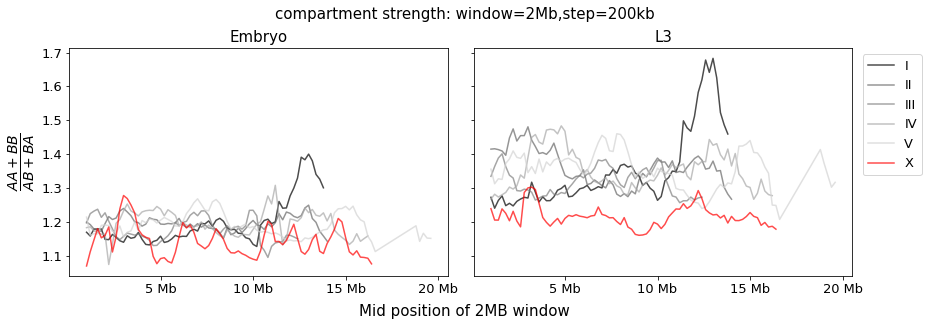

In [50]:
f, axs = plt.subplots(
    figsize=(13, 4),
    nrows=1,
    ncols=2,
    sharex=True,
    sharey=True
)

dat = COMP_sliders_emb_pd
dat1 = COMP_sliders_L3_pd
## compute mid
dat['mid'] = (dat['end']+dat['start'])/2
dat1['mid'] = (dat1['end']+dat1['start'])/2


# global param
subtitles = ['Embryo','L3']
yminmax = [1.1,1.7]
colors = ['black','dimgrey','grey','darkgrey','lightgrey','red']
smallFont = 13
bigFont = 15


sns.lineplot(ax=axs[0],data=dat[dat['valid']==True], x='mid', y='COMP_1', hue='chrom',palette=colors,alpha=0.7)
sns.lineplot(ax=axs[1],data=dat1[dat1['valid']==True], x='mid', y='COMP_1', hue='chrom',palette=colors,alpha=0.7)


for i in range(2):
    axs[i].set_title(subtitles[i],fontsize=bigFont)
    axs[i].set_xlabel('')
    axs[i].tick_params(axis='both', labelsize=smallFont)
    axs[i].locator_params(axis='x', nbins=5)
    format_ticks(axs[i],x=True,y=False,rotate=False)


axs[0].set_ylabel(r"$\frac{AA + BB}{AB + BA}$",rotation=90,fontsize=20, labelpad=4)



axs[0].get_legend().remove()
hand, labl = axs[1].get_legend_handles_labels()
axs[1].legend(labl,bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1,prop={'size': 13})

    
f.text(0.50, 1, 'compartment strength: window=2Mb,step=200kb', ha='center',fontsize=bigFont)        
f.text(0.50, -0.03, 'Mid position of 2MB window', ha='center',fontsize=bigFont)    
plt.tight_layout()



In [51]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig1s_COMP_slider_N2.pdf',dpi=800,bbox_inches='tight')

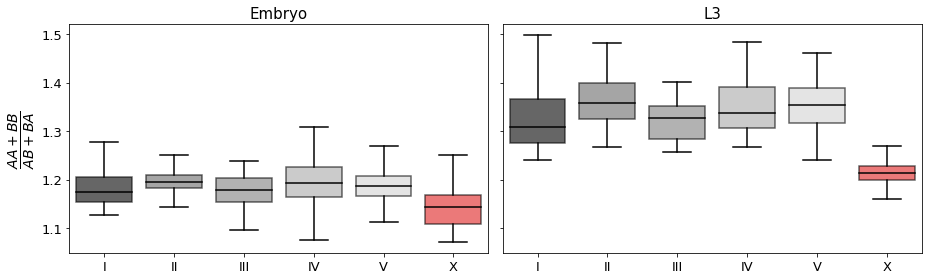

In [53]:
f, axs = plt.subplots(
    figsize=(13, 4),
    nrows=1,
    ncols=2,
    sharex=True,
    sharey=True
)

dat = COMP_sliders_emb_pd
dat1 = COMP_sliders_L3_pd
## compute mid
dat['mid'] = (dat['end']+dat['start'])/2
dat1['mid'] = (dat1['end']+dat1['start'])/2


# global param
colors = ['black','dimgrey','grey','darkgrey','lightgrey','red']
smallFont = 13
bigFont = 15


sns.boxplot(ax=axs[0],data=dat[dat['valid']==True],
            x='chrom', y='COMP_1',palette=colors,showfliers=False,boxprops=dict(alpha=0.6))
sns.boxplot(ax=axs[1],data=dat1[dat1['valid']==True],
            x='chrom', y='COMP_1',palette=colors,showfliers=False,boxprops=dict(alpha=0.6))

for i in range(2):
    axs[i].set_title(subtitles[i],fontsize=bigFont)
    axs[i].set_xlabel('')
    axs[i].tick_params(axis='both', labelsize=smallFont)

axs[0].set_ylabel(r"$\frac{AA + BB}{AB + BA}$",rotation=90,fontsize=20, labelpad=4)
axs[1].set_ylabel('')
#format_ticks(axs[1],x=True,y=False,rotate=False)
plt.tight_layout()

In [54]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig1s_COMP_slider_N2_boxplot.pdf',dpi=800,bbox_inches='tight')

In [37]:
########################################## end of compartments ###################################################

/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
<ipython-input-10-7c1cabc55daa>:298: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


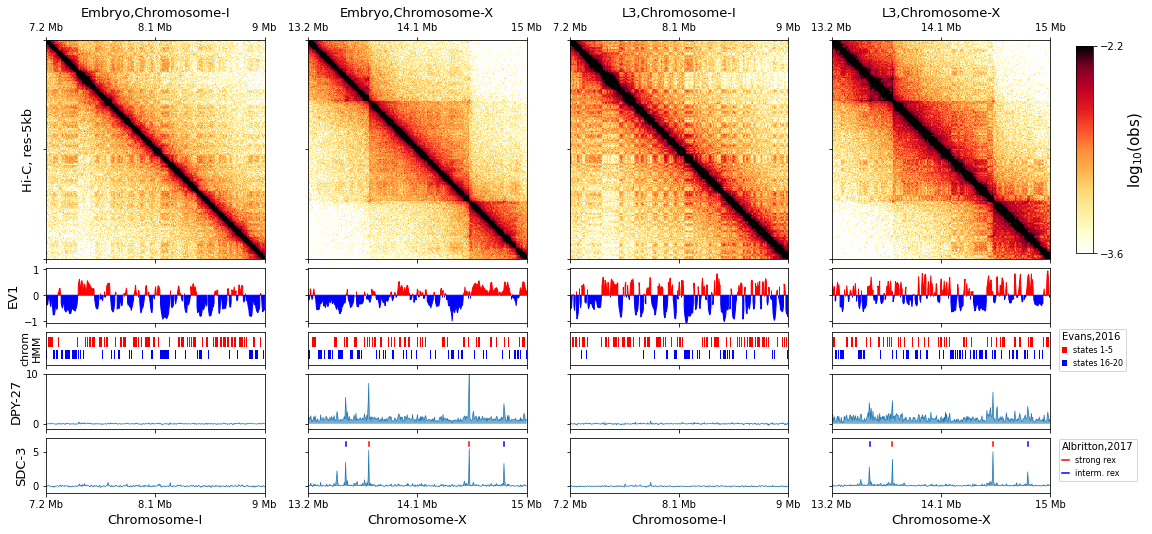

In [10]:
######################################## snap shot ########################################

region_I = 'I:7,200,000-9,000,000'
start_I, end_I = 7_200_000, 9_000_000
chromo_I = 'I'
chrom_I = 'chrI'


region_X = 'X:13,200,000-15,000,000'
start_X, end_X = 13_200_000, 15_000_000
chromo_X = 'X'
chrom_X = 'chrX'


pad_param = 0.13
HMMsize = "15%"
signalsize = "25%"

dev_stage = ['Embryo','L3']
norm = LogNorm(vmin=0.00025,vmax=0.006)
ic_min,ic_max = [-3.6,-2.2]
oe_min,oe_max = [-0.9,0.9]
#bw_norm = 'symlog'
bw_norm = 'n'
E1_min, E1_max = [-1.05,1.05]
bw_min, bw_max = [-1,10]
sdc3_min, sdc3_max = [-1,7]
#### HMM param ####
A_ymin,A_ymax = [0.08,0.12]
B_ymin,B_ymax = [0.02,0.06]
HMM_lw = 0.3

##############

f, axs = plt.subplots(
    figsize=(15, 9),
    nrows=1,
    ncols=4,
    sharex=False,
    sharey=False
)

clrs = [clr_emb_5kb,clr_L3_5kb]

#loopsizes = [pick_loopsize(agg_emb_center),pick_loopsize(agg_L3_center)]
#exps_I = [exp_I_center_emb,exp_I_center_L3]
#exps_X = [exp_X_center_emb,exp_X_center_L3]

bws_dpy27 = [dpy27_emb,dpy27_L3]
bws_sdc3 = [sdc3_emb,sdc3_L3]
bws_E1 = [E1_emb,E1_L3]
HMM_states = [categorize_HMM2(HMM_emb_bg),categorize_HMM2(HMM_L3_bg)]

############################################# chromosome-I #########################################    
region = region_I
start, end = start_I, end_I
extents = (start,end,end,start)
chromo = chromo_I
chrom = chrom_I
ticks = list(range(start,end+1,900000))

for i in range(2):
    #ax2 = axs[i]
    ax1 = axs[2*i]
    clr_region = cgi_region(clrs[i],region)
    im1 = ax1.matshow(
        np.log10(clr_region),
        cmap='fall',
        extent=extents,
        vmin=ic_min,vmax=ic_max)
    divider = make_axes_locatable(ax1)
    
    ########## chrI EV #########
    ax2 = divider.append_axes("bottom", size=signalsize, pad=pad_param)    
    bw_region = bws_E1[i].stats(chrom,start,end,type="mean",nBins=len(clr_region))
    xval = np.linspace(start, end, len(clr_region))
    yval = np.array(bw_region, dtype=float)
    mask = np.isfinite(yval)
    ax2.plot(
        xval[mask],
        yval[mask],lw=0.02,color='black',alpha=0)
    plt.fill_between(xval[mask],0,yval[mask],where=yval[mask]>0,interpolate=False,color='red')
    plt.fill_between(xval[mask],0,yval[mask],where=yval[mask]<0,interpolate=False,color='blue')
    ax2.set_ylim([E1_min,E1_max])
    plt.xlim([xval.min(), xval.max()])
    
    ########## chrI HMM #########
    ax_hmm = divider.append_axes("bottom", size=HMMsize, pad=pad_param)
    A_annot = bed3_mids2(HMM_states[i][0],'chrI',start,end)
    B_annot = bed3_mids2(HMM_states[i][1],'chrI',start,end)
    yMax = 5
    x = 0.8 # spacing between border and rectangle
    z = 0.5 # spacing between A and B
    y = (yMax-2*x-z) / 2 # height of rectangle
    
    for k in range(len(A_annot['start'])):
        ax_hmm.add_patch(Rectangle((A_annot['start'][k], x+y+z), A_annot['end'][k]-A_annot['start'][k], y,
                                   edgecolor = None,facecolor = 'red'))
    for k in range(len(B_annot['start'])):
        ax_hmm.add_patch(Rectangle((B_annot['start'][k], x), B_annot['end'][k]-B_annot['start'][k], y,
                                   edgecolor = None,facecolor = 'blue'))
    plt.xlim([start, end])
    plt.ylim([0, yMax])
    
    ######### chrI DPY27 #########
    ax3 = divider.append_axes("bottom", size=signalsize, pad=pad_param)
    bw_region = bws_dpy27[i].stats(chrom,start,end,type="mean",nBins=len(clr_region))
    xval = np.linspace(start, end, len(clr_region))
    yval = np.array(bw_region, dtype=float)
    mask = np.isfinite(yval)
    ax3.plot(
        xval[mask],
        yval[mask],lw=0.7)
    plt.fill_between(xval[mask],0,yval[mask],interpolate=False,alpha=0.6)
    ax3.set_ylim([bw_min,bw_max])
    plt.xlim([xval.min(), xval.max()])
    if bw_norm == 'symlog':
        ax3.set_yscale('symlog')
    ######### chrI SDC3 #########
    ax4 = divider.append_axes("bottom", size=signalsize, pad=pad_param)
    bw_region = bws_sdc3[i].stats(chrom,start,end,type="mean",nBins=len(clr_region))
    xval = np.linspace(start, end, len(clr_region))
    yval = np.array(bw_region, dtype=float)
    mask = np.isfinite(yval)
    ax4.plot(
        xval[mask],
        yval[mask],lw=0.7)
    plt.fill_between(xval[mask],0,yval[mask],interpolate=False,alpha=0.6)
    ax4.set_ylim([sdc3_min,sdc3_max])
    plt.xlim([xval.min(), xval.max()])

        
    ## chromosome-I ticks/labels ##
    format_ticks(ax1,x=True,y=True,rotate=False)
    format_ticks(ax4,x=True,y=False,rotate=False)    
    ax1.tick_params(axis="x", bottom=True, top=True, labelbottom=False, labeltop=True)
    
    ax1.axes.get_yaxis().set_ticklabels([])
    ax2.axes.get_xaxis().set_ticklabels([])
    ax3.axes.get_xaxis().set_ticklabels([])
    ax_hmm.axes.get_xaxis().set_ticklabels([])
    ax_hmm.axes.get_yaxis().set_ticklabels([])
    ax1.set_title(dev_stage[i]+',Chromosome-I',fontsize=13)
    ax4.set_xlabel('Chromosome-I',fontsize=13)
    
    if i == 0:
        ax1.set_ylabel('Hi-C, res-5kb',fontsize=13)
        ax2.set_ylabel('EV1',fontsize=13)
        ax_hmm.set_ylabel('chrom\nHMM',fontsize=11)
        ax3.set_ylabel('DPY-27',fontsize=13)
        ax4.set_ylabel('SDC-3',fontsize=13)
    if i == 1:
        ax2.axes.get_yaxis().set_ticklabels([])
        ax3.axes.get_yaxis().set_ticklabels([])
        ax4.axes.get_yaxis().set_ticklabels([])
    ax1.set_xticks(ticks)
    ax1.set_yticks(ticks)
    ax2.set_xticks(ticks)
    ax_hmm.set_xticks(ticks)
    ax_hmm.set_yticks([])
    ax3.set_xticks(ticks)
    ax4.set_xticks(ticks)
############################################# chromosome-X #########################################    
region = region_X
start, end = start_X, end_X
extents = (start,end,end,start)
chromo = chromo_X
chrom = chrom_X
ticks = list(range(start,end+1,900000))

for i in range(2):
    ax1 = axs[2*i+1]
    clr_region = cgi_region(clrs[i],region)
    im1 = ax1.matshow(
        np.log10(clr_region),
        cmap='fall',
        extent=extents,
        vmin=ic_min,vmax=ic_max)
    divider = make_axes_locatable(ax1)
    
    
    ########## chrX EV #########
    ax2 = divider.append_axes("bottom", size=signalsize, pad=pad_param)    
    bw_region = bws_E1[i].stats(chrom,start,end,type="mean",nBins=len(clr_region))
    xval = np.linspace(start, end, len(clr_region))
    yval = np.array(bw_region, dtype=float)
    mask = np.isfinite(yval)
    ax2.plot(
        xval[mask],
        yval[mask],lw=0.02,color='black',alpha=0)
    plt.fill_between(xval[mask],0,yval[mask],where=yval[mask]>0,interpolate=False,color='red')
    plt.fill_between(xval[mask],0,yval[mask],where=yval[mask]<0,interpolate=False,color='blue')
    ax2.set_ylim([E1_min,E1_max])
    plt.xlim([xval.min(), xval.max()])

    ########## chrX HMM #########
    ax_hmm = divider.append_axes("bottom", size=HMMsize, pad=pad_param)
    A_annot = bed3_mids2(HMM_states[i][0],'chrX',start,end)
    B_annot = bed3_mids2(HMM_states[i][1],'chrX',start,end)
    yMax = 5
    x = 0.8 # spacing between border and rectangle
    z = 0.5 # spacing between A and B
    y = (yMax-2*x-z) / 2 # height of rectangle
    
    for k in range(len(A_annot['start'])):
        ax_hmm.add_patch(Rectangle((A_annot['start'][k], x+y+z), A_annot['end'][k]-A_annot['start'][k], y,
                                   edgecolor = None,facecolor = 'red',label='states 1-5'))
    for k in range(len(B_annot['start'])):
        ax_hmm.add_patch(Rectangle((B_annot['start'][k], x), B_annot['end'][k]-B_annot['start'][k], y,
                                   edgecolor = None,facecolor = 'blue',label='states 16-20'))

    plt.xlim([start, end])
    plt.ylim([0, yMax])

    ######### chrX DPY27 #########
    ax3 = divider.append_axes("bottom", size=signalsize, pad=pad_param)
    bw_region = bws_dpy27[i].stats(chrom,start,end,type="mean",nBins=len(clr_region))
    xval = np.linspace(start, end, len(clr_region))
    yval = np.array(bw_region, dtype=float)
    mask = np.isfinite(yval)
    ax3.plot(
        xval[mask],
        yval[mask],lw=0.7)
    plt.fill_between(xval[mask],0,yval[mask],interpolate=False,alpha=0.6)
    ax3.set_ylim([bw_min,bw_max])
    plt.xlim([xval.min(), xval.max()])
    if bw_norm == 'symlog':
        ax3.set_yscale('symlog')
    
    ######### chrX SDC3 #########
    ax4 = divider.append_axes("bottom", size=signalsize, pad=pad_param)
    bw_region = bws_sdc3[i].stats(chrom,start,end,type="mean",nBins=len(clr_region))
    xval = np.linspace(start, end, len(clr_region))
    yval = np.array(bw_region, dtype=float)
    mask = np.isfinite(yval)
    ax4.plot(
        xval[mask],
        yval[mask],lw=0.7)
    plt.fill_between(xval[mask],0,yval[mask],interpolate=False,alpha=0.6)
    ax4.set_ylim([sdc3_min,sdc3_max])
    plt.xlim([xval.min(), xval.max()])
        
        
    ## chromosome-X ticks/labels ##
    format_ticks(ax1,x=True,y=True,rotate=False)
    format_ticks(ax4,x=True,y=False,rotate=False)    
    ax1.tick_params(axis="x", bottom=True, top=True, labelbottom=False, labeltop=True)
    
    ax1.axes.get_yaxis().set_ticklabels([])
    ax2.axes.get_xaxis().set_ticklabels([])
    ax3.axes.get_xaxis().set_ticklabels([])
    ax_hmm.axes.get_xaxis().set_ticklabels([])
    ax_hmm.axes.get_yaxis().set_ticklabels([])
    ax1.set_title(dev_stage[i]+',Chromosome-X',fontsize=13)
    ax4.set_xlabel('Chromosome-X',fontsize=13)
    
    ax2.axes.get_yaxis().set_ticklabels([])
    ax3.axes.get_yaxis().set_ticklabels([])
    ax4.axes.get_yaxis().set_ticklabels([])
    ax1.set_xticks(ticks)
    ax1.set_yticks(ticks)
    ax2.set_xticks(ticks)
    ax3.set_xticks(ticks)
    ax4.set_xticks(ticks)
    ax_hmm.set_xticks(ticks)
    ax_hmm.set_yticks([])
    
    
    ## rex annot ##
    strong_annot = bed3_mids(strong,'X',start,end)
    intermediate_annot = bed3_mids(intermediate,'X',start,end)
    weak_annot = bed3_mids(weak,'X',start,end)
    for a in range(len(strong_annot)):
        ax4.axvline(x=strong_annot[a],ymin=0.85,ymax=0.93,c="red",alpha=1,label='strong rex')
    for a in range(len(intermediate_annot)):
        ax4.axvline(x=intermediate_annot[a],ymin=0.85,ymax=0.93,c="blue",alpha=1,label='interm. rex')
    if i == 1:
    ## HMM legend ##
        handles, labels = ax_hmm.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        leg = f.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.05, 0.41),prop={'size': 8},
                       handlelength=0.6,title='Evans,2016')
        leg._legend_box.align = "left"
    
    ## rex legend ##
        handles, labels = ax4.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        leg = f.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.06, 0.240),prop={'size': 8},
                       handlelength=0.8,title='Albritton,2017')
        leg._legend_box.align = "left"

## cbar ##
cbaxes = f.add_axes([1, .520, 0.015, 0.32]) 
cbar = plt.colorbar(im1, cax = cbaxes,ticks=[ic_min,ic_max])
cbar.ax.get_yaxis().labelpad = 2
cbar.ax.set_ylabel('$\log_{10}$(obs)', rotation=90,fontsize=15)
    
plt.tight_layout()



In [6]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig1_snapshot_5kbHiC.pdf',dpi=1200,bbox_inches='tight')

In [ ]:
########################################## beginning of pile up ###################################################

In [5]:
########## pile-ups at rex #################
flank=500000
resolution=5000
ce10_X = ce10.iloc[[5]].reset_index(drop=True)
add_mid(strong)
windows_strong = add_windows(strong,ce10_X)


In [10]:
########### expected X for oe ###############
clrs_cond = [clr_emb_5kb,clr_L3_5kb]
clrs_cond_expX = []
for s in range(len(clrs_cond)):
    x = my_expected(clrs_cond[s],ce10_X)
    clrs_cond_expX.append(x)


In [11]:
#### pile up at rex ####
pup_obs_oe = []
for s in range(len(clrs_cond_expX)):
    x = my_pup_clr(clrs_cond[s],windows_strong,ce10.iloc[[5]].reset_index(drop=True))
    y = my_pup_oe(clrs_cond[s],windows_strong,ce10.iloc[[5]].reset_index(drop=True),clrs_cond_expX[s])
    pup_obs_oe.append([x,y])

<ipython-input-8-e1e2dda97095>:271: RuntimeWarning: Mean of empty slice
  expected_avg = np.nanmean(oe_stack, axis=2)


<ipython-input-94-f32267e93213>:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


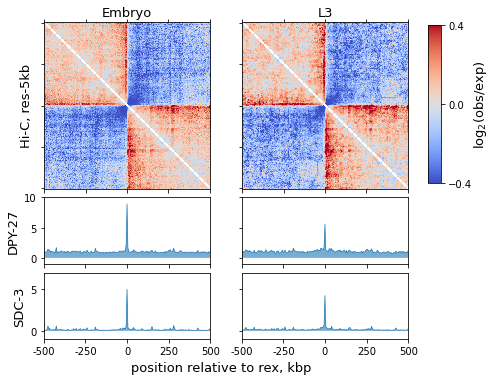

In [94]:
######### rex pile up only obs/exp ###########

f, axs = plt.subplots(
    figsize=(6,8),
    ncols=2,nrows=1,
    sharey=True,
    sharex=True)
    
start, end = [0,flank*2//resolution]
ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)


bws1 = [dpy27_emb,dpy27_L3]
bws2 = [sdc3_emb,sdc3_L3]
bws = [bws1,bws2]

Alpha = 0.8
lineWidth = 0.6
bigFont = 13
smallFont = 10
minmax_oe = [-0.4,0.4]
minmax_bws = [[-1,10],[-1,7]]
sub_titles = ['Embryo','L3']
ChIP_labels = ['DPY-27','SDC-3']

for s in range(len(pup_obs_oe)):
    ax_oe = axs[s]
    
    ## obs/exp ##
    im_oe = ax_oe.matshow(
        np.log2(pup_obs_oe[s][1]),
        cmap='coolwarm',
        vmin=minmax_oe[0],vmax=minmax_oe[1]
    )
    divider = make_axes_locatable(ax_oe)
    
    ## ChIPseq ##
    xval = np.linspace(start, end,len(pup_obs_oe[s][1]))

    for i in range(len(bws)):
        ax1 = divider.append_axes("bottom", size="40%", pad=0.12)
        a = bwTobedMatrix(bws[i][s],windows_strong,len(pup_obs_oe[s][1]))
        yval = np.nanmean(a,axis=0,dtype=float)
        mask = np.isfinite(yval)
        ax1.plot(
            xval[mask],
            yval[mask],lw=0.7, label='rex pileup')
        ax1.fill_between(xval[mask],0,yval[mask],interpolate=False, alpha=0.6)
        ax1.set_xlim([xval.min(), xval.max()])
        ax1.set_ylim([minmax_bws[i][0],minmax_bws[i][1]])
        ax1.set(xticks=ticks_pixels,
                xticklabels=ticks_kbp)
        ax1.set(xticks=ticks_pixels,xticklabels=[])
        ax1.tick_params(labelsize=smallFont)
        if s == 0:
            ax1.set_ylabel(ChIP_labels[i],size=bigFont)
        else:
            ax1.set(yticklabels=[])
    ## labeling ##
    ax_oe.set(xticks=ticks_pixels,yticks=ticks_pixels,xticklabels=[],yticklabels=[])
    ax_oe.set_title(sub_titles[s],fontsize=bigFont)
    ax1.set(xticks=ticks_pixels,xticklabels=ticks_kbp)
    
    if s == 0:
        ax_oe.set_ylabel('Hi-C, res-5kb',size=bigFont)

cbaxes_oe = f.add_axes([1.000001, .496, 0.03, 0.275])  
cbar_oe = plt.colorbar(im_oe, cax = cbaxes_oe,ticks=[-0.4,0,0.4])
cbar_oe.ax.get_yaxis().labelpad = 6
cbar_oe.ax.set_ylabel('$\log_2$(obs/exp)', rotation=90,fontsize=bigFont, labelpad=-0.2)

f.text(0.52, 0.17, 'position relative to rex, kbp', ha='center',fontsize=bigFont)

plt.tight_layout()

In [95]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig1_rex_pileup_5kbHiC.pdf',dpi=800,bbox_inches='tight')

In [124]:
############################ beginning of Ps #############################
#### Ps, reps split XA ####
clrs_reps = [clr_emb_1,clr_emb_2,clr_L3_1,clr_L3_2]

agg_XA_clrs_reps = []
for i in range(len(clrs_reps)):
    agg_XA = []
    a = scaling_agg(clrs_reps[i],ce10.iloc[0:4].reset_index(drop=True))
    x = scaling_agg(clrs_reps[i],ce10.iloc[[5]].reset_index(drop=True))
    agg_XA.append(a)
    agg_XA.append(x)
    agg_XA_clrs_reps.append(agg_XA)

400765.31294620084
200117.95526829833
400765.4410563783
200118.96911583713
400763.60983180837
158418.80098624332
504598.0799016067
158421.68486411372


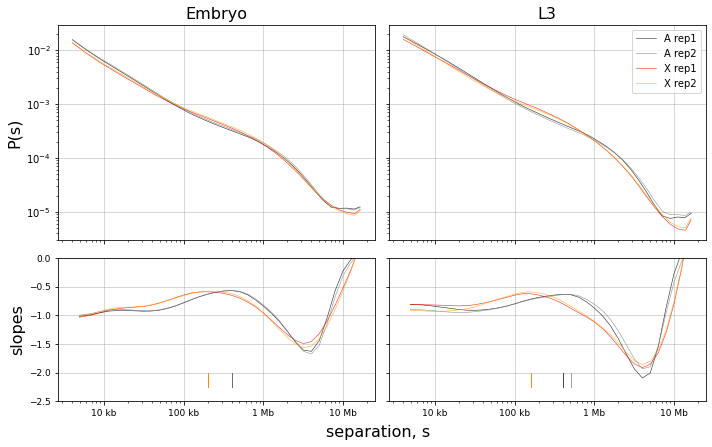

In [126]:
########################## Ps, slopes, split reps ############################
f, axs = plt.subplots(
    figsize=(10,6),
    ncols=2,
    nrows=2,
    sharex=True, sharey='row',
    gridspec_kw={'height_ratios':[6,4]}
)

# sample grouping #
emb_reps = [agg_XA_clrs_reps[0],agg_XA_clrs_reps[1]]
L3_reps = [agg_XA_clrs_reps[2],agg_XA_clrs_reps[3]]

sample_grps = [emb_reps,L3_reps]
# structure: layer1=conditions, layer2=reps, layer3=A,X, layer4=ps,slopes,loopsize #

# global params and labels #
Alpha = 0.8
lineWidth = 0.6
bigFont = 16
smallFont = 9
slopes_minmax = [-2.5,0]
subtitles = ['Embryo','L3']
labels = [['A rep1','X rep1'], ['A rep2', 'X rep2']]
colors = [['black','red'],['grey','orange']]

# plot #
for s in range(len(sample_grps)):
    dat_agg = sample_grps[s]
    ax1 = axs[0,s]
    ax2 = axs[1,s]
    for i in range(len(dat_agg)):
        for j in range(len(dat_agg[i])):
            ax1.loglog(
                dat_agg[i][j][0]['s_bp'],
                dat_agg[i][j][0]['balanced.avg'],
                label=labels[i][j],
                color=colors[i][j],linewidth=lineWidth,alpha=Alpha
            )
            ax2.semilogx(
                dat_agg[i][j][1]['s_bp'],
                dat_agg[i][j][1]['slope'],
                label=labels[i][j],
                color=colors[i][j],linewidth=lineWidth,alpha=Alpha
            )
            loopmin = dat_agg[i][j][2]>50000
            loopmax = dat_agg[i][j][2]<1000000
            loopsize = max(dat_agg[i][j][2][np.logical_and(loopmin,loopmax)])
            print(loopsize)
            ax2.axvline(x=loopsize,ymin=0.1,ymax=0.2,c=colors[i][j],lw=0.9,alpha=Alpha)
            
    ax1.grid(lw=0.5)
    ax2.grid(lw=0.5)
    format_ticks(ax2,y=False,rotate=False)
    ax2.tick_params(labelsize=smallFont)
    ax2.set_ylim(slopes_minmax)
    
    ax1.set_title(subtitles[s],size=bigFont)

# ylabel
axs[0,0].set_ylabel('P(s)',size=bigFont)
axs[1,0].set_ylabel('slopes',size=bigFont)

# big xlabel
f.text(0.53, -0.02, 'separation, s', ha='center',fontsize=bigFont)

#add legend to plot
handles, labels = axs[0,1].get_legend_handles_labels()
order = [0,2,1,3]
axs[0,1].legend([handles[idx] for idx in order],[labels[idx] for idx in order])



plt.tight_layout()

In [127]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig1_Ps_reps_XAsplit_HiC2kb.pdf',dpi=800,bbox_inches='tight')

In [20]:
########################## make cartoon of genome ###################

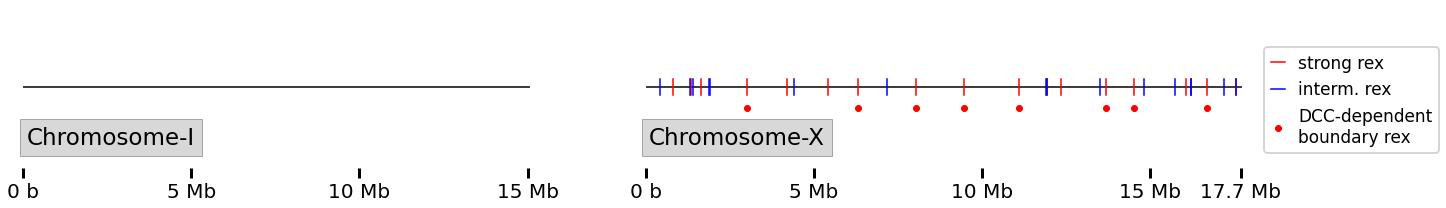

In [14]:
########################## cartoon of global annotation ############################
f, axs = plt.subplots(
    figsize=(18,3),
    ncols=2,
    nrows=1,
    sharex=False,sharey=True
)

size_I = 15072423
size_X = 17718866
start_I, end_I = 7_200_000, 9_000_000
start_X, end_X = 13_200_000, 15_000_000

# global param
boxheight = 1.5

# chromosome-I
ax1 = axs[0]
ax1.hlines(0,0,size_I,color='black') 
ax1.set_ylim([-2,2])
#rect = patches.Rectangle((start_I, 0-boxheight/2), end_I-start_I, boxheight, linewidth=1.5, 
#                         edgecolor='none', facecolor='grey',alpha=0.25,label='snapshot')
#ax1.add_patch(rect)
ax1.set_xlim([0,size_X])



# chromosome-X
ax2 = axs[1]
ax2.hlines(0,0,size_X,color='black') 
ax2.set_ylim([-2,2])
ax2.set_xlim([0,size_X])

annots = [strong,intermediate,DCCdep]
labels = ['strong rex','interm. rex','DCC-dependent\nboundary rex']
colors = ['red','blue','red']
tickProp = 0.1

annot_leg = []
for i in range(len(annots)):
    annot_i = bed3_mids(annots[i],'X',0,size_X)
    for a in range(len(annot_i)):
        if i < 2:
            ax2.axvline(x=annot_i[a],ymin=0.5-tickProp/2,ymax=0.5+tickProp/2,c=colors[i],alpha=1,label=labels[i])
        if i == 2:
            ax2.plot(annot_i[a], -0.5, 'o',color=colors[i],label=labels[i])
        
#rect = patches.Rectangle((start_X, 0-boxheight/2), end_X-start_X, boxheight, linewidth=1.5,
#                         edgecolor='none', facecolor='grey',alpha=0.25,label='snapshot')
#ax2.add_patch(rect)

for i in range(2):
    axs[i].spines['left'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].get_yaxis().set_ticks([])
    format_ticks(axs[i],x=True,y=False,rotate=False)
    axs[i].tick_params(axis='x', which='major', labelsize=20)
    axs[i].xaxis.set_tick_params(width=3,length=10)

axs[0].set_xticks([0,5_000_000,10_000_000,15_000_000])
axs[1].set_xticks([0,5_000_000,10_000_000,15_000_000,17_700_000])



ax1.text(100_000, -1.4, 'Chromosome-I', fontsize=23,
        bbox={'facecolor': 'grey', 'alpha': 0.3, 'pad': 7})
ax2.text(100_000, -1.4, 'Chromosome-X', fontsize=23,
        bbox={'facecolor': 'grey', 'alpha': 0.3, 'pad': 7})

## legend ##
handles, labels = ax2.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
leg = f.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.12, 0.8),prop={'size': 17},
               handlelength=0.8)
leg._legend_box.align = "left"
leg.get_frame().set_linewidth(2)
        
plt.tight_layout()

In [15]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig1_cartoon.pdf',dpi=800,bbox_inches='tight')